# Issues with temperature and buoyancy resolved

October 8th. Current overview of calculations is given below.

### Exner function
`exner = (p_level / p_0) ** (R_d / c_p)`

### Temperature
`T = theta_l * exner + (L_v * l_level) / c_p`

### Potential temperature
`theta = T / exner`

### Virtual temperature
`theta_v = theta * (1 + ep2 * q_v - l_level)`

### Reference virtual temperature
```
lw_threshold = 1e-5
non_cloudy_mask = l_level < lw_threshold

if np.any(non_cloudy_mask):
    theta_v_0 = np.mean(theta_v[non_cloudy_mask])
else:
    # Fallback: Use the mean of theta over the entire level
    theta_v_0 = np.mean(theta_v)
```

### Buoyancy 
`B =  g * ((theta_v / theta_v_0) - 1)`


Remnant of the old calculation below

In [ ]:
# timestep = 20      # Specify the timestep you want to extract
# height_index = 45   # Index of the height level you want to extract

# # Select the height level
# t_level = t[height_index, :, :]
# q_level = q[height_index, :, :]
# l_level = l[height_index, :, :]
# p_level = p[height_index, :, :]
# w_level = w[height_index, :, :]  # Vertical velocity at the specified height

# # Compute q_v (Vapor Mixing Ratio)
# q_v = q_level - l_level

# # Compute θ_l (Liquid Water Potential Temperature)
# theta_l = t_level

# # Exner function
# cpr = R_d / c_p
# exner = (p_level / p_0) ** cpr

# # Compute temperature T
# T = theta_l * exner + (L_v * l_level) / c_p

# # Compute full potential temperature θ
# theta = T / exner

# # Create a mask for non-cloudy areas
# lw_threshold = 1e-5
# non_cloudy_mask = l_level < lw_threshold

# # Compute virtual temperature
# theta_v = theta * (1 + ep2 * q_v - l_level)

# # Compute reference virtual temperature over non-cloudy areas
# if np.any(non_cloudy_mask):
#     theta_v_0 = np.mean(theta_v[non_cloudy_mask])
# else:
#     # Fallback: Use the mean of theta over the entire level
#     theta_v_0 = np.mean(theta_v)
#     print("Warning: No non-cloudy areas found at this level. Using mean theta over the entire level.")

# # Compute Buoyancy
# B =  g * ((theta_v / theta_v_0) - 1)

# Overview of datasets

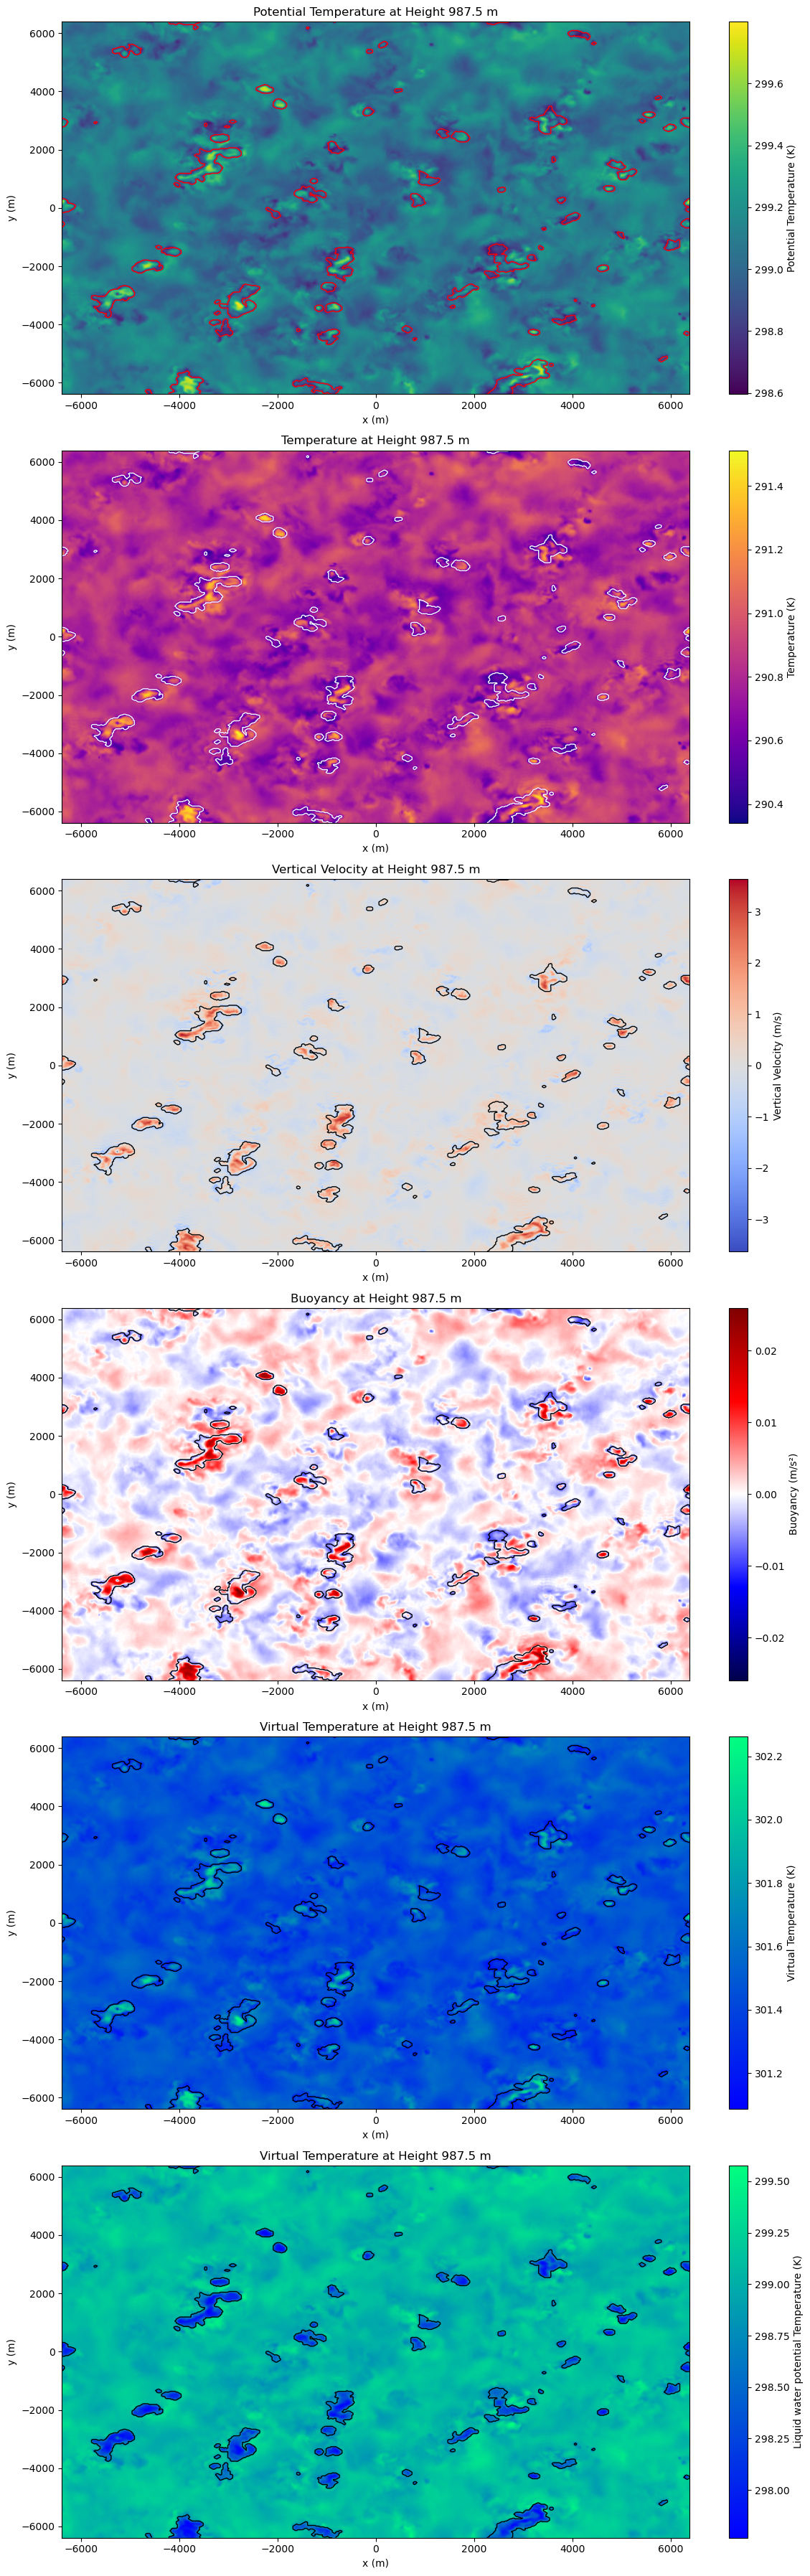

In [13]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

lw_threshold = 1e-6

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def load_xy_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
    return x_values, y_values

# File paths (Update these paths to match your file locations)
temp_file = '/Users/jure/PhD/coding/RICO_1hr/rico.temp.nc'           # Temperature file
potential_temp_file = '/Users/jure/PhD/coding/RICO_1hr/rico.potential_temp.nc'  # Potential Temperature file
virtual_temp_file = '/Users/jure/PhD/coding/RICO_1hr/rico.virtual_temp.nc'      # Virtual Temperature file
buoyancy_file = '/Users/jure/PhD/coding/RICO_1hr/rico.buoyancy.nc'              # Buoyancy file
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'                # Vertical velocity file
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'                # Liquid water content file
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'                # Pressure file
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'                # Liquid water potential temperature file

timestep = 15       # Specify the timestep you want to extract
height_index = 40   # Index of the height level you want to extract

# Load data from NetCDF files
T = load_data_all_levels(temp_file, 'temperature', timestep)
theta = load_data_all_levels(potential_temp_file, 'potential_temperature', timestep)
theta_v = load_data_all_levels(virtual_temp_file, 'virtual_temperature', timestep)
theta_l = load_data_all_levels(t_file, 't', timestep)
B = load_data_all_levels(buoyancy_file, 'buoyancy', timestep)
w = load_data_all_levels(w_file, 'w', timestep)
l = load_data_all_levels(l_file, 'l', timestep)
p = load_data_all_levels(p_file, 'p', timestep)


# Load zt, x, y values
zt = load_zt_values(p_file)  # Assuming zt is the same in all files
x_values, y_values = load_xy_values(p_file)

# Select the height level
T_level = T[height_index, :, :]
theta_level = theta[height_index, :, :]
theta_v_level = theta_v[height_index, :, :]
theta_l_level = theta_l[height_index, :, :]
B_level = B[height_index, :, :]
w_level = w[height_index, :, :]
l_level = l[height_index, :, :]
p_level = p[height_index, :, :]


# Create a figure with five subplots
fig, axs = plt.subplots(6, 1, figsize=(12, 36))  # 5 rows, 1 column

# Plotting Potential Temperature θ
im0 = axs[0].imshow(
    theta_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0], label='Potential Temperature (K)')
axs[0].set_title(f'Potential Temperature at Height {zt[height_index]:.1f} m')
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')
contour_levels = [lw_threshold]
cs0_contour = axs[0].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='red', linewidths=1)

# Plotting Temperature T
im1 = axs[1].imshow(
    T_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='plasma')
fig.colorbar(im1, ax=axs[1], label='Temperature (K)')
axs[1].set_title(f'Temperature at Height {zt[height_index]:.1f} m')
axs[1].set_xlabel('x (m)')
axs[1].set_ylabel('y (m)')
cs1_contour = axs[1].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='white', linewidths=1)

# Plotting Vertical Velocity w
w_abs_max = max(abs(np.min(w_level)), abs(np.max(w_level)))  # Define limits to center around 0
im2 = axs[2].imshow(
    w_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='coolwarm', vmin=-w_abs_max, vmax=w_abs_max)
fig.colorbar(im2, ax=axs[2], label='Vertical Velocity (m/s)')
axs[2].set_title(f'Vertical Velocity at Height {zt[height_index]:.1f} m')
axs[2].set_xlabel('x (m)')
axs[2].set_ylabel('y (m)')
cs2_contour = axs[2].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1)

# Plotting Buoyancy B
B_abs_max = max(abs(np.min(B_level)), abs(np.max(B_level)))  # Define limits to center around 0
im3 = axs[3].imshow(
    B_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='seismic', vmin=-B_abs_max, vmax=B_abs_max)
fig.colorbar(im3, ax=axs[3], label='Buoyancy (m/s²)')
axs[3].set_title(f'Buoyancy at Height {zt[height_index]:.1f} m')
axs[3].set_xlabel('x (m)')
axs[3].set_ylabel('y (m)')
cs3_contour = axs[3].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1)

# Plotting Virtual Temperature θ_v
im4 = axs[4].imshow(
    theta_v_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='winter')
fig.colorbar(im4, ax=axs[4], label='Virtual Temperature (K)')
axs[4].set_title(f'Virtual Temperature at Height {zt[height_index]:.1f} m')
axs[4].set_xlabel('x (m)')
axs[4].set_ylabel('y (m)')
cs4_contour = axs[4].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1)

# Plotting Virtual Temperature θ_v
im5 = axs[5].imshow(
    theta_l_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='winter')
fig.colorbar(im5, ax=axs[5], label='Liquid Water Potential Temperature (K)')
axs[5].set_title(f'Liquid Water Potential Temperature at Height {zt[height_index]:.1f} m')
axs[5].set_xlabel('x (m)')
axs[5].set_ylabel('y (m)')
cs5_contour = axs[5].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1)

plt.tight_layout()
# plt.savefig('new_temp_and_buoyancy.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Distance from cloud edge


Processing timestep 1...
Processing timestep 2...
Processing timestep 3...
Processing timestep 4...
Processing timestep 5...
Processing timestep 6...
Processing timestep 7...
Processing timestep 8...
Processing timestep 9...
Processing timestep 10...
Processing timestep 11...
Processing timestep 12...
Processing timestep 13...
Processing timestep 14...
Processing timestep 15...
Processing timestep 16...
Processing timestep 17...
Processing timestep 18...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_83346/956410210.py:112: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_arrays, axis=0)


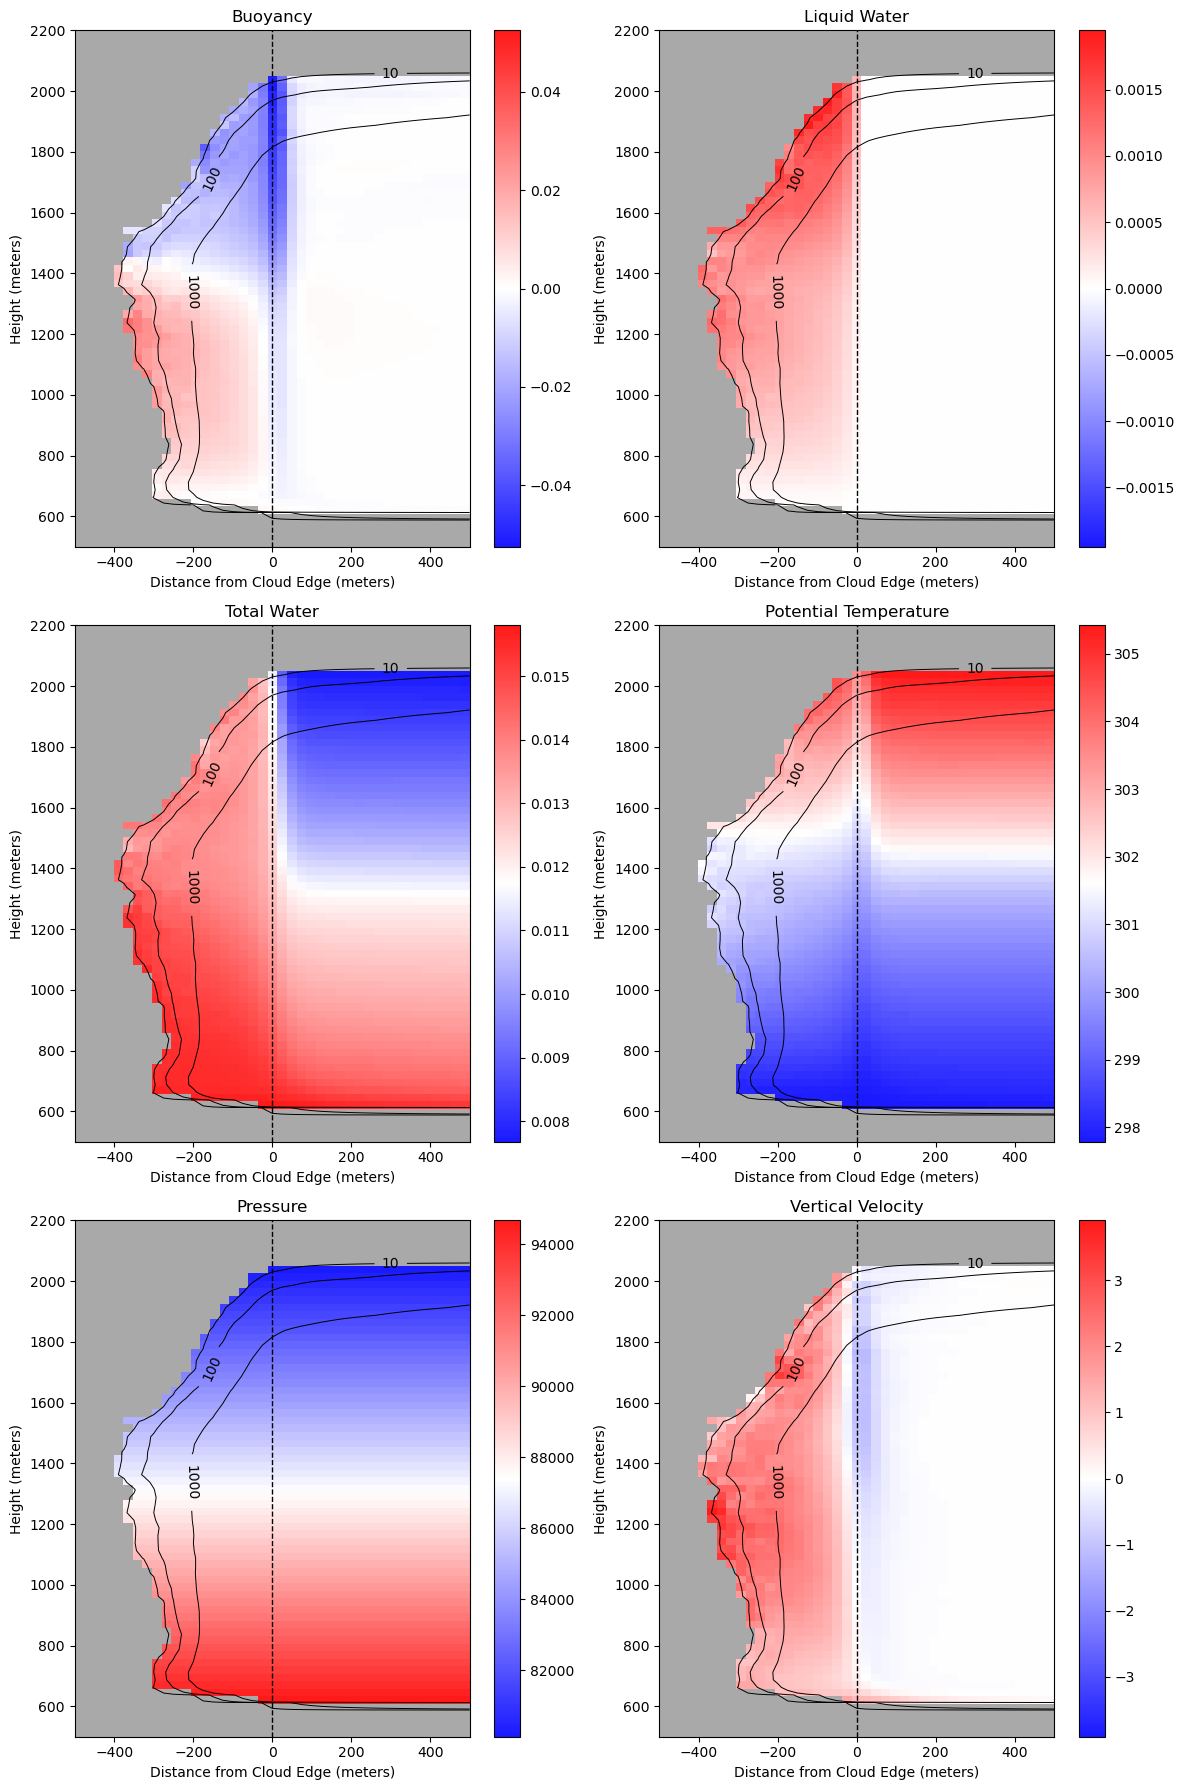

In [16]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_cdt
from matplotlib.colors import Normalize, ListedColormap

horizontal_resolution = 25  # Horizontal resolution in meters

w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'                   # Vertical velocity
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'                   # Liquid water mixing ratio
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'                   # Total water mixing ratio
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'                   # Liquid Water Potential Temperature
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'                   # Pressure
buoyancy_file = '/Users/jure/PhD/coding/RICO_1hr/rico.buoyancy.nc'     # Buoyancy
theta_l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.potential_temp.nc'  # Potential Temperature

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
        if var_name in ['l', 'q']:
            data = data  # Convert from g/kg to kg/kg if necessary
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_values_vs_distance(
    buoyancy_data, liquid_water_data, total_water_data, theta_l_data,
    pressure_data, w_data, cloud_mask, max_distance):
    """Calculate values as a function of distance from cloud edge for various variables."""
    height_levels = buoyancy_data.shape[0]
    total_distance = max_distance * 2 + 1  # Negative to positive distances
    results = {
        'buoyancy': np.full((height_levels, total_distance), np.nan),
        'liquid_water': np.full((height_levels, total_distance), np.nan),
        'total_water': np.full((height_levels, total_distance), np.nan),
        'theta_l': np.full((height_levels, total_distance), np.nan),
        'pressure': np.full((height_levels, total_distance), np.nan),
        'w': np.full((height_levels, total_distance), np.nan),
        'cloud_count': np.zeros((height_levels, total_distance), dtype=int)
    }

    for z in range(height_levels):
        region_cloud_mask = cloud_mask[z]

        # Only proceed if there are clouds at this height level
        if np.any(region_cloud_mask):
            # Compute distances inside the cloud and shift so cloud edge is distance 0
            distance_inward = distance_transform_cdt(region_cloud_mask, metric='taxicab')
            distances_inside = -distance_inward + 1  # Shift distances so cloud edge is at 0

            # Compute distances outside the cloud
            distance_outward = distance_transform_cdt(~region_cloud_mask, metric='taxicab')
            distances_outside = distance_outward

            # Combine distances
            distances = np.full(region_cloud_mask.shape, np.nan)
            distances[region_cloud_mask] = distances_inside[region_cloud_mask]
            distances[~region_cloud_mask] = distances_outside[~region_cloud_mask]

            # Convert distances to integer type
            distances = distances.astype(int)

            # Calculate each variable for each distance
            for distance in range(-max_distance, max_distance + 1):
                indices = np.where(distances == distance)
                if len(indices[0]) > 0:
                    idx_z = z
                    idx_d = distance + max_distance  # Adjust index for negative distances
                    results['buoyancy'][idx_z, idx_d] = np.mean(buoyancy_data[idx_z, indices[0], indices[1]])
                    results['liquid_water'][idx_z, idx_d] = np.mean(liquid_water_data[idx_z, indices[0], indices[1]])
                    results['total_water'][idx_z, idx_d] = np.mean(total_water_data[idx_z, indices[0], indices[1]])
                    results['theta_l'][idx_z, idx_d] = np.mean(theta_l_data[idx_z, indices[0], indices[1]])
                    results['pressure'][idx_z, idx_d] = np.mean(pressure_data[idx_z, indices[0], indices[1]])
                    results['w'][idx_z, idx_d] = np.mean(w_data[idx_z, indices[0], indices[1]])
                    results['cloud_count'][idx_z, idx_d] += len(indices[0])

    return results


def process_multiple_timesteps_with_edge(timesteps, max_distance):
    all_results = []

    for timestep in timesteps:
        print(f"Processing timestep {timestep}...")
        theta_l_data = load_data_all_levels(theta_l_file, 'potential_temperature', timestep)
        p_data = load_data_all_levels(p_file, 'p', timestep)
        q_t_data = load_data_all_levels(q_file, 'q', timestep)
        q_l_data = load_data_all_levels(l_file, 'l', timestep)
        w_data = load_data_all_levels(w_file, 'w', timestep)
        buoyancy_data = load_data_all_levels(buoyancy_file, 'buoyancy', timestep)

        # Create a cloud mask based on the liquid water threshold
        cloud_mask = q_l_data > 1e-6  # Adjust the threshold as needed

        # Calculate values for each variable as a function of distance from the cloud edge
        results = calculate_values_vs_distance(
            buoyancy_data, q_l_data, q_t_data, theta_l_data, p_data, w_data, cloud_mask, max_distance)
        all_results.append(results)

    # Initialize mean_results to accumulate the data
    mean_results = {}

    # Combine results across timesteps
    for key in all_results[0].keys():
        if key == 'cloud_count':
            mean_results[key] = np.nansum([result[key] for result in all_results], axis=0)
        else:
            stacked_arrays = np.array([result[key] for result in all_results])
            mean_results[key] = np.nanmean(stacked_arrays, axis=0)

    return mean_results

# Parameters for distance and resolution
timesteps = list(range(1, 19))  # Adjust the range as needed
max_distance_in_meters = 500    # Maximum distance from cloud edge in meters
max_distance = max_distance_in_meters // horizontal_resolution  # Convert to grid points

# Run the calculation
mean_results = process_multiple_timesteps_with_edge(timesteps, max_distance)

# Create distances in meters
distance_in_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# Load height levels in meters
zt_values = load_zt_values(t_file)

# Define custom contour levels
custom_contour_levels = np.array([10, 100, 1000])  # Modify as needed

# Plotting multiple variables (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
variables = ['buoyancy', 'liquid_water', 'total_water', 'theta_l', 'pressure', 'w']
titles = ['Buoyancy', 'Liquid Water', 'Total Water', 'Potential Temperature', 'Pressure', 'Vertical Velocity']

for ax, var, title in zip(axs.flat, variables, titles):
    data = np.ma.masked_invalid(mean_results[var])

    # Modify colormap
    cmap = plt.get_cmap('bwr')
    cmap = cmap(np.arange(cmap.N))
    cmap[:, -1] = 0.9  # Set alpha
    cmap = ListedColormap(cmap)
    cmap.set_bad(color='darkgrey')

    # Adjust the color bar
    data_min, data_max = np.nanmin(data), np.nanmax(data)
    if var in ['total_water', 'theta_l', 'pressure']:
        norm = Normalize(vmin=data_min, vmax=data_max)
    else:
        norm = Normalize(vmin=-np.nanmax(np.abs(data)), vmax=np.nanmax(np.abs(data)))

    # Plot the data
    im = ax.imshow(
        data, cmap=cmap, norm=norm, origin='lower', aspect='auto',
        extent=[distance_in_meters[0], distance_in_meters[-1], zt_values[0], zt_values[-1]])
    ax.set_title(title)
    ax.set_xlabel('Distance from Cloud Edge (meters)')
    ax.set_ylabel('Height (meters)')
    ax.set_ylim(500, 2200)  # Adjust height limits as needed
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Cloud Edge')

    # Add color bar
    fig.colorbar(im, ax=ax)

    # Overlay cloud count as contour
    cloud_count = mean_results['cloud_count']
    if custom_contour_levels is not None:
        levels = custom_contour_levels
    else:
        levels = np.linspace(np.min(cloud_count), np.max(cloud_count), 10)
    cs = ax.contour(
        distance_in_meters, zt_values, cloud_count, levels=levels, colors='black', linewidths=0.7)
    ax.clabel(cs, fmt='%d')

plt.tight_layout()
#plt.savefig('near_environment.pdf', format='pdf', bbox_inches='tight')
plt.show()


## Normalised distance

In [41]:
#  Needs to be done!

## Difference between cloud and environment
Mean cloud value at given height minus the value of a point.
todo: should be done as in-cloud average for each cloud and minus it and then average it. 

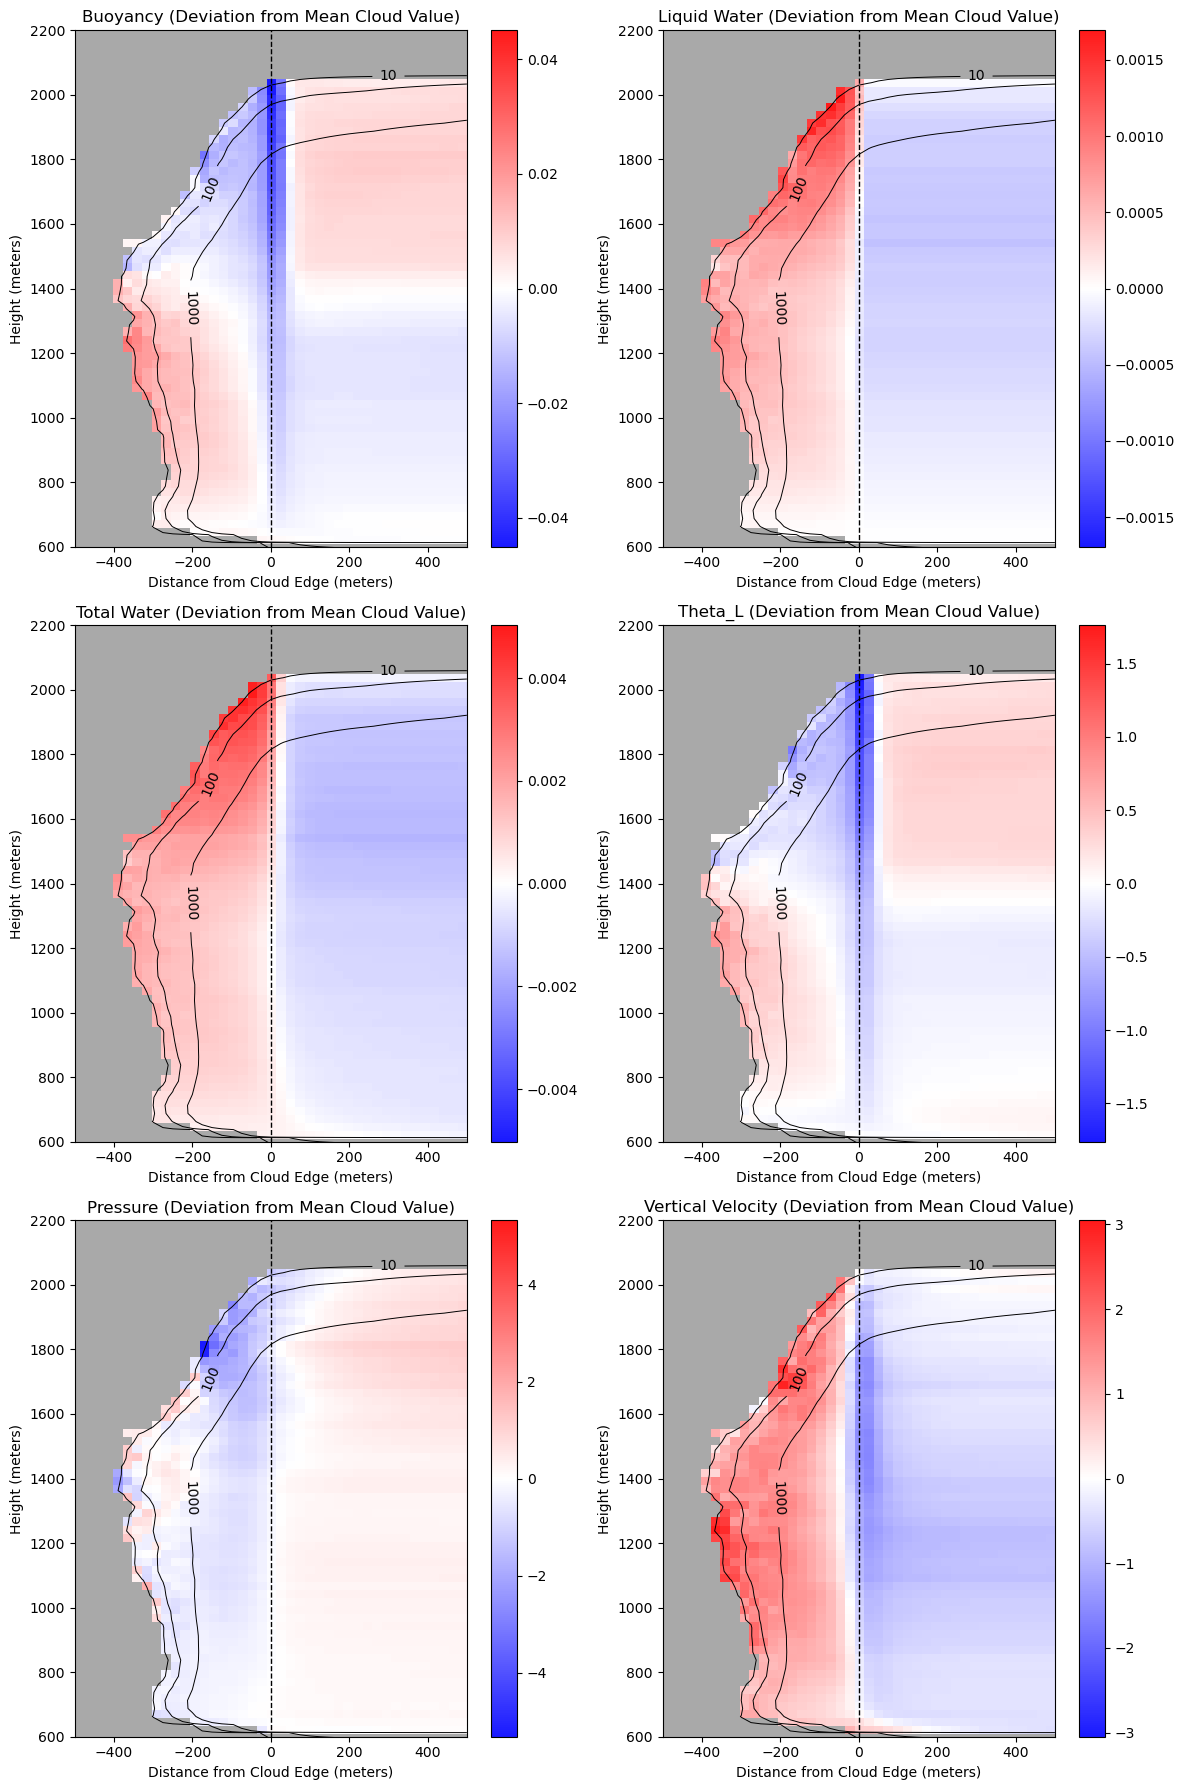

In [17]:
# Define custom contour levels for cloud count (you can modify these)
custom_contour_levels = np.array([10, 100, 1000])  # Example: focus on lower numbers

# Plotting multiple variables (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
variables = ['buoyancy', 'liquid_water', 'total_water', 'theta_l', 'pressure', 'w']
titles = ['Buoyancy', 'Liquid Water', 'Total Water', 'Theta_L', 'Pressure', 'Vertical Velocity']

for ax, var, title in zip(axs.flat, variables, titles):
    data = np.ma.masked_invalid(mean_results[var])
    
    # Calculate the mean cloud value for each height level
    mean_cloud_values = np.zeros(data.shape[0])
    for z in range(data.shape[0]):
        cloud_points = data[z, :]  # All points at this height level
        cloud_mask_at_z = ~np.isnan(cloud_points)  # Use non-NaN values as cloud points
        if np.any(cloud_mask_at_z):
            mean_cloud_values[z] = np.nanmean(cloud_points[cloud_mask_at_z])
        else:
            mean_cloud_values[z] = np.nan  # No cloud points at this height

    # Subtract the mean cloud value at each height level from all points at that height
    for z in range(data.shape[0]):
        data[z, :] -= mean_cloud_values[z]
    
    # Modify colormap for each plot
    cmap = plt.get_cmap('bwr')
    cmap = cmap(np.arange(cmap.N))
    cmap[:, -1] = 0.9  # Set alpha to 0.9 for all colors (transparency)
    cmap = ListedColormap(cmap)
    cmap.set_bad(color='darkgrey')

    # Adjust the color bar to emphasize 0 and use the actual data range
    data_min, data_max = np.nanmin(data), np.nanmax(data)
    data_abs_max = max(abs(data_min), abs(data_max))
    norm = Normalize(vmin=-data_abs_max, vmax=data_abs_max)
    
    # Plot the data
    im = ax.imshow(data, cmap=cmap, norm=norm, origin='lower', aspect='auto',
                   extent=[distance_in_meters[0], distance_in_meters[-1], zt_values[0], zt_values[-1]])
    ax.set_title(f"{title} (Deviation from Mean Cloud Value)")
    ax.set_xlabel('Distance from Cloud Edge (meters)')
    ax.set_ylabel('Height (meters)')
    
    # Set the y-axis limit between 500 and 2200 meters
    ax.set_ylim(600, 2200)
    
    # Add a vertical line at x=0 to denote the cloud edge
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Cloud Edge')
    
    # Add color bar for each subplot
    fig.colorbar(im, ax=ax)

    # Overlay cloud count as contour
    cloud_count = mean_results['cloud_count']  # Access the cloud count data
    
    # Check if custom contour levels are provided
    if custom_contour_levels is not None:
        levels = custom_contour_levels  # Use the custom levels
    else:
        levels = np.linspace(np.min(cloud_count), np.max(cloud_count), 10)  # Default to 10 evenly spaced levels
    
    # Plot the contour with the chosen levels
    cs = ax.contour(distance_in_meters, zt_values, cloud_count, levels=levels, colors='black', linewidths=0.7)
    ax.clabel(cs, fmt='%d')  # Label contour lines with numbers

# Display the plot
plt.tight_layout()
#plt.savefig('near_environment_difference.pdf', format='pdf')
plt.show()


# Updated (incorrect) decomposition plots

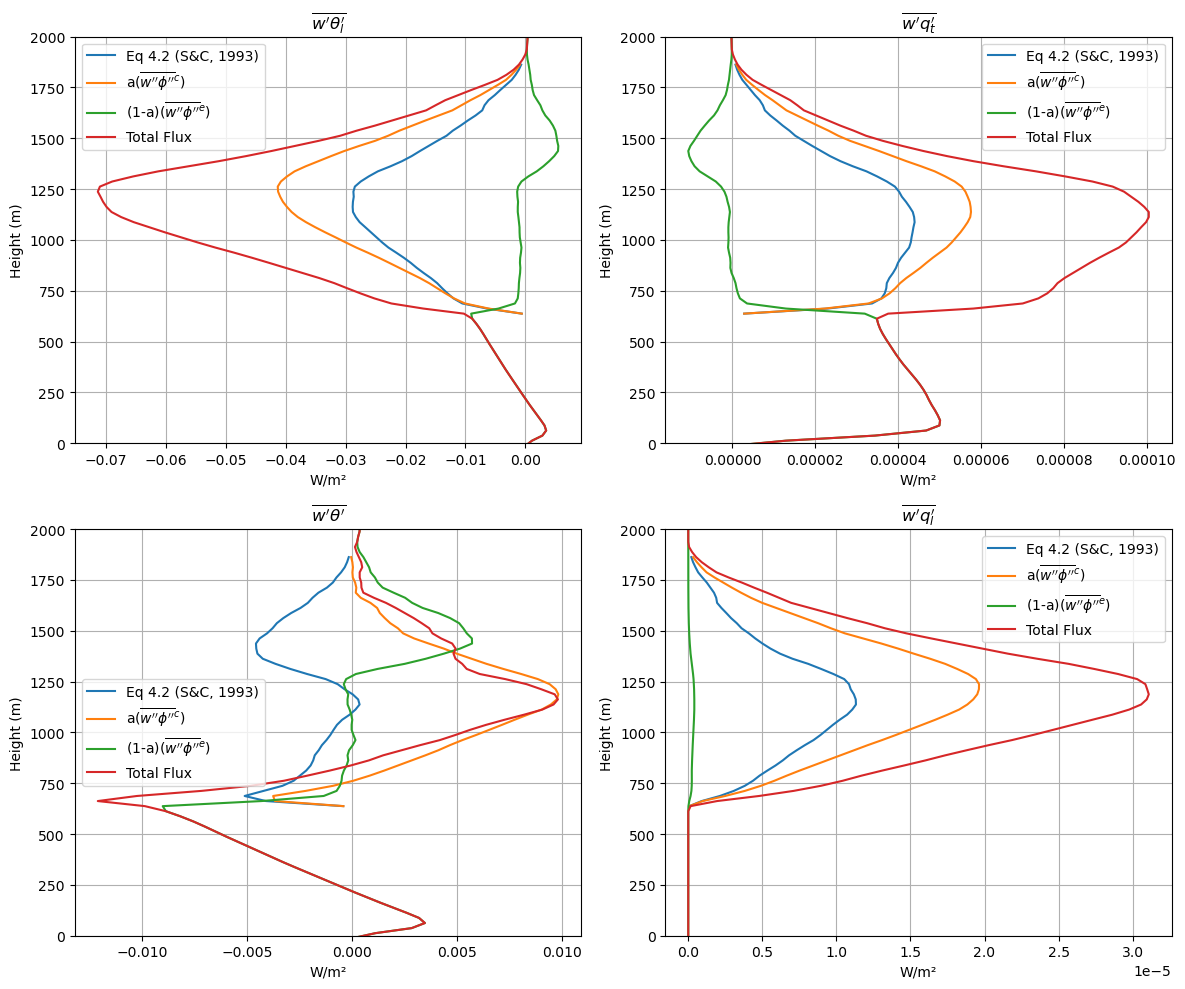

In [3]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt

# # Thresholds
# liquid_water_threshold = 1e-5

# # Constants
# rho_0 = 1.25       # kg/m^3
# L_v = 2268000.0    # J/kg latent heat of vaporization
# c_p = 1004.0       # J/kg/K specific heat capacity at constant pressure
# R_d = 287.05       # J/kg/K gas constant for dry air
# p_0 = 100000.0     # Pa standard pressure at sea level

# # File paths
# w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
# l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'
# q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'
# t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'
# p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'
# potential_temp_file = '/Users/jure/PhD/coding/RICO_1hr/rico.potential_temp.nc'

# def load_data_all_levels(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         data = ds[var_name][timestep, :, :, :].astype(np.float64)
#     return data

# def load_zt_values(filename):
#     with nc.Dataset(filename) as ds:
#         zt_values = ds['zt'][:]
#     return zt_values

# def calculate_M_c_values(w_data, l_data, variable_data, liquid_water_threshold, multiplier):
#     M_c_values = []
#     active_cloudy_values = []
#     environment_values = []
#     total_flux_values = []

#     for z in range(w_data.shape[0]):
#         # Cloudy and environment masks
#         cloudy_mask = l_data[z, :, :] > liquid_water_threshold
#         environment_mask = ~cloudy_mask

#         # Area fractions
#         a = np.mean(cloudy_mask)

#         # Mean vertical velocities and variable contents
#         w_mean = np.mean(w_data[z, :, :])
#         var_mean = np.mean(variable_data[z, :, :])

#         # Check for empty masks to avoid errors
#         if np.any(cloudy_mask):
#             w_c = np.mean(w_data[z, :, :][cloudy_mask])
#             var_c = np.mean(variable_data[z, :, :][cloudy_mask])
#             w_prime_c = w_data[z, :, :][cloudy_mask] - w_mean
#             var_prime_c = variable_data[z, :, :][cloudy_mask] - var_mean
#             line1 = a * np.mean(w_prime_c * var_prime_c) * multiplier
#         else:
#             w_c = np.nan
#             var_c = np.nan
#             line1 = np.nan

#         if np.any(environment_mask):
#             w_e = np.mean(w_data[z, :, :][environment_mask])
#             var_e = np.mean(variable_data[z, :, :][environment_mask])
#             w_prime_e = w_data[z, :, :][environment_mask] - w_mean
#             var_prime_e = variable_data[z, :, :][environment_mask] - var_mean
#             line2 = (1 - a) * np.mean(w_prime_e * var_prime_e) * multiplier
#         else:
#             w_e = np.nan
#             var_e = np.nan
#             line2 = np.nan

#         # Calculate M_c
#         if not np.isnan(w_c) and not np.isnan(w_e) and not np.isnan(var_c) and not np.isnan(var_e):
#             M_c = a * (1 - a) * (w_c - w_e)
#             result = M_c * (var_c - var_e) * multiplier
#         else:
#             result = np.nan

#         # Append the result for the current vertical level
#         M_c_values.append(result)
#         active_cloudy_values.append(line1)
#         environment_values.append(line2)

#         # Calculate total flux using np.nansum to handle NaNs
#         total_flux = np.nansum([result, line1, line2])
#         total_flux_values.append(total_flux)

#     # Convert the result lists to numpy arrays
#     M_c_values = np.array(M_c_values)
#     active_cloudy_values = np.array(active_cloudy_values)
#     environment_values = np.array(environment_values)
#     total_flux_values = np.array(total_flux_values)

#     return M_c_values, active_cloudy_values, environment_values, total_flux_values

# def average_M_c_values_over_time(start_timestep, end_timestep, variable_data_loader, multiplier):
#     M_c_values_total = None
#     active_cloudy_values_total = None
#     environment_values_total = None
#     total_flux_values_total = None

#     num_timesteps = end_timestep - start_timestep

#     for timestep in range(start_timestep, end_timestep):
#         w_data = load_data_all_levels(w_file, 'w', timestep)
#         l_data = load_data_all_levels(l_file, 'l', timestep)
#         variable_data = variable_data_loader(timestep)

#         M_c_values, active_cloudy_values, environment_values, total_flux_values = calculate_M_c_values(
#             w_data, l_data, variable_data, liquid_water_threshold, multiplier
#         )

#         if M_c_values_total is None:
#             M_c_values_total = M_c_values
#             active_cloudy_values_total = active_cloudy_values
#             environment_values_total = environment_values
#             total_flux_values_total = total_flux_values
#         else:
#             M_c_values_total += M_c_values
#             active_cloudy_values_total += active_cloudy_values
#             environment_values_total += environment_values
#             total_flux_values_total += total_flux_values

#     M_c_values_total /= num_timesteps
#     active_cloudy_values_total /= num_timesteps
#     environment_values_total /= num_timesteps
#     total_flux_values_total /= num_timesteps

#     return M_c_values_total, active_cloudy_values_total, environment_values_total, total_flux_values_total

# # Specify the time range to analyze
# start_timestep = 15
# end_timestep = 18

# # Load height values
# zt_values = load_zt_values(l_file)

# # Calculate and average M_c values for liquid water content
# M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values = average_M_c_values_over_time(
#     start_timestep, end_timestep, lambda timestep: load_data_all_levels(l_file, 'l', timestep), 1)

# # Calculate and average M_c values for total water content
# M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values = average_M_c_values_over_time(
#     start_timestep, end_timestep, lambda timestep: load_data_all_levels(q_file, 'q', timestep), 1)

# # Calculate and average M_c values for liquid water potential temperature
# M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values = average_M_c_values_over_time(
#     start_timestep, end_timestep, lambda timestep: load_data_all_levels(t_file, 't', timestep), 1)

# # Calculate and average M_c values for potential temperature (theta) by loading it directly
# def variable_data_loader_theta(timestep):
#     theta_data = load_data_all_levels(potential_temp_file, 'potential_temperature', timestep)
#     return theta_data

# M_c_theta_values, active_cloudy_theta_values, environment_theta_values, total_flux_theta_values = average_M_c_values_over_time(
#     start_timestep, end_timestep, variable_data_loader_theta, 1)

# # Plotting
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# def plot_with_additional_lines(ax, M_c_values, active_cloudy_values, environment_values, total_flux_values, title):
#     ax.plot(M_c_values, zt_values, label='Eq 4.2 (S&C, 1993)')
#     ax.plot(active_cloudy_values, zt_values, label='a($\\overline{w\'\'\\phi\'\'}^c$)')
#     ax.plot(environment_values, zt_values, label='(1-a)($\\overline{w\'\'\\phi\'\'}^e$)')
#     ax.plot(total_flux_values, zt_values, label='Total Flux')

#     ax.set_xlabel('Flux')
#     ax.set_ylabel('Height (m)')
#     ax.set_title(title)
#     ax.grid(True)
#     ax.set_ylim([0, 2000])
#     ax.legend()

# plot_with_additional_lines(ax1, M_c_theta_l_values, active_cloudy_theta_l_values, environment_theta_l_values, total_flux_theta_l_values, r'$\overline{w^{\prime}\theta_l^{\prime}}$')
# plot_with_additional_lines(ax2, M_c_qt_values, active_cloudy_qt_values, environment_qt_values, total_flux_qt_values, r'$\overline{w^{\prime}q_t^{\prime}}$')
# plot_with_additional_lines(ax3, M_c_theta_values, active_cloudy_theta_values, environment_theta_values, total_flux_theta_values, r'$\overline{w^{\prime}\theta^{\prime}}$')
# plot_with_additional_lines(ax4, M_c_l_values, active_cloudy_l_values, environment_l_values, total_flux_l_values, r'$\overline{w^{\prime}q_l^{\prime}}$')

# plt.tight_layout()
# plt.show()


## Leaner (incorrect) code

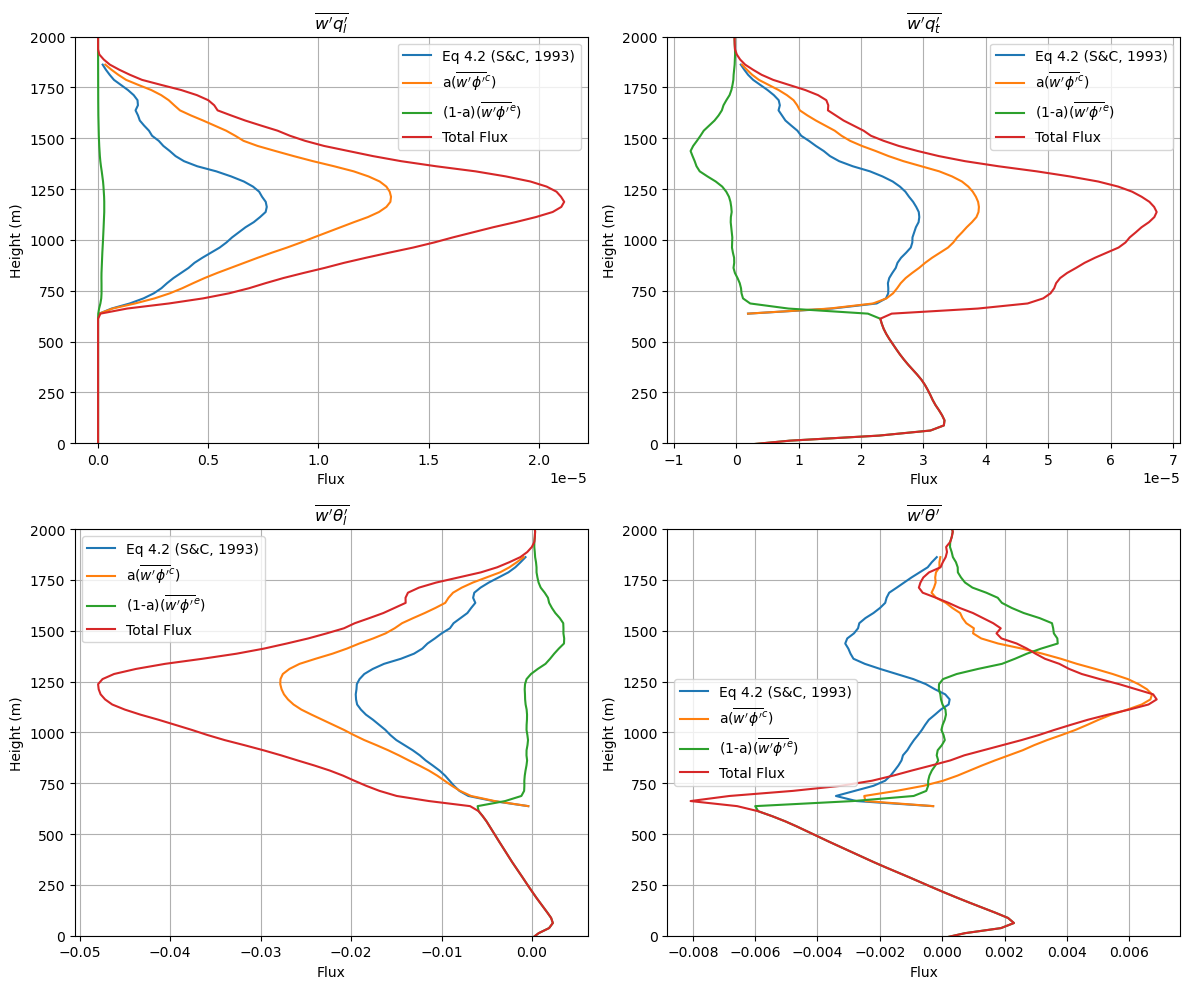

In [1]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt

# # Threshold for liquid water content
# liquid_water_threshold = 1e-5

# # File paths
# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

# files = {
#     'w': data_dir + 'rico.w.nc',
#     'l': data_dir + 'rico.l.nc',
#     'q': data_dir + 'rico.q.nc',
#     't': data_dir + 'rico.t.nc',
#     'p': data_dir + 'rico.p.nc',
#     'theta': data_dir + 'rico.potential_temp.nc'
# }

# # Variable names in NetCDF files
# var_names = {
#     'w': 'w',
#     'l': 'l',
#     'q': 'q',
#     't': 't',
#     'theta': 'potential_temperature'
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         return ds[var_name][timestep].astype(np.float64)

# def load_zt(filename):
#     with nc.Dataset(filename) as ds:
#         return ds['zt'][:]

# def calculate_M_c(w_data, l_data, var_data):
#     M_c_values = []
#     active_cloudy_values = []
#     environment_values = []
#     total_flux_values = []

#     # Loop over vertical levels
#     for z in range(w_data.shape[0]):
#         # Masks
#         cloudy = l_data[z] > liquid_water_threshold
#         environment = ~cloudy

#         # Area fraction
#         a = np.mean(cloudy)

#         # Means
#         w_mean = np.mean(w_data[z])
#         var_mean = np.mean(var_data[z])

#         # Initialize variables
#         w_c = np.nan
#         var_c = np.nan
#         w_e = np.nan
#         var_e = np.nan

#         # Cloudy calculations
#         if np.any(cloudy):
#             w_c = np.mean(w_data[z][cloudy])
#             var_c = np.mean(var_data[z][cloudy])
#             line1 = a * np.mean((w_data[z][cloudy] - w_mean) * (var_data[z][cloudy] - var_mean))
#         else:
#             line1 = np.nan

#         # Environment calculations
#         if np.any(environment):
#             w_e = np.mean(w_data[z][environment])
#             var_e = np.mean(var_data[z][environment])
#             line2 = (1 - a) * np.mean((w_data[z][environment] - w_mean) * (var_data[z][environment] - var_mean))
#         else:
#             line2 = np.nan

#         # Mass flux term
#         if not any(np.isnan([w_c, w_e, var_c, var_e])):
#             M_c = a * (1 - a) * (w_c - w_e) * (var_c - var_e)
#         else:
#             M_c = np.nan

#         # Total flux
#         total_flux = np.nansum([M_c, line1, line2])

#         # Append results
#         M_c_values.append(M_c)
#         active_cloudy_values.append(line1)
#         environment_values.append(line2)
#         total_flux_values.append(total_flux)

#     return map(np.array, [M_c_values, active_cloudy_values, environment_values, total_flux_values])

# def average_over_time(start, end, var_key):
#     num_steps = end - start
#     M_c_sum = None

#     for t in range(start, end):
#         w_data = load_data(files['w'], var_names['w'], t)
#         l_data = load_data(files['l'], var_names['l'], t)
#         var_data = load_data(files[var_key], var_names[var_key], t)

#         results = calculate_M_c(w_data, l_data, var_data)

#         if M_c_sum is None:
#             M_c_sum = [np.zeros_like(r) for r in results]

#         for i, r in enumerate(results):
#             M_c_sum[i] += r

#     # Average over time
#     return [r / num_steps for r in M_c_sum]

# # Time range
# start_timestep = 15
# end_timestep = 18

# # Load height values
# zt_values = load_zt(files['l'])

# # Variables to process with their titles
# variables = {
#     'l': r'$\overline{w^{\prime}q_l^{\prime}}$',
#     'q': r'$\overline{w^{\prime}q_t^{\prime}}$',
#     't': r'$\overline{w^{\prime}\theta_l^{\prime}}$',
#     'theta': r'$\overline{w^{\prime}\theta^{\prime}}$'
# }

# # Store results
# results = {}

# for var_key, title in variables.items():
#     results[var_key] = {}
#     M_c_values, active_cloudy, environment, total_flux = average_over_time(start_timestep, end_timestep, var_key)
#     results[var_key]['M_c'] = M_c_values
#     results[var_key]['active_cloudy'] = active_cloudy
#     results[var_key]['environment'] = environment
#     results[var_key]['total_flux'] = total_flux
#     results[var_key]['title'] = title

# # Plotting
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# axs = axs.flatten()

# for ax, (var_key, res) in zip(axs, results.items()):
#     ax.plot(res['M_c'], zt_values, label='Eq 4.2 (S&C, 1993)')
#     ax.plot(res['active_cloudy'], zt_values, label='a($\\overline{w\'\\phi\'}^c$)')
#     ax.plot(res['environment'], zt_values, label='(1-a)($\\overline{w\'\\phi\'}^e$)')
#     ax.plot(res['total_flux'], zt_values, label='Total Flux')

#     ax.set_xlabel('Flux')
#     ax.set_ylabel('Height (m)')
#     ax.set_title(res['title'])
#     ax.grid(True)
#     ax.set_ylim([0, 2000])
#     ax.legend()

# plt.tight_layout()
# plt.show()


## Independently calculated total flux line

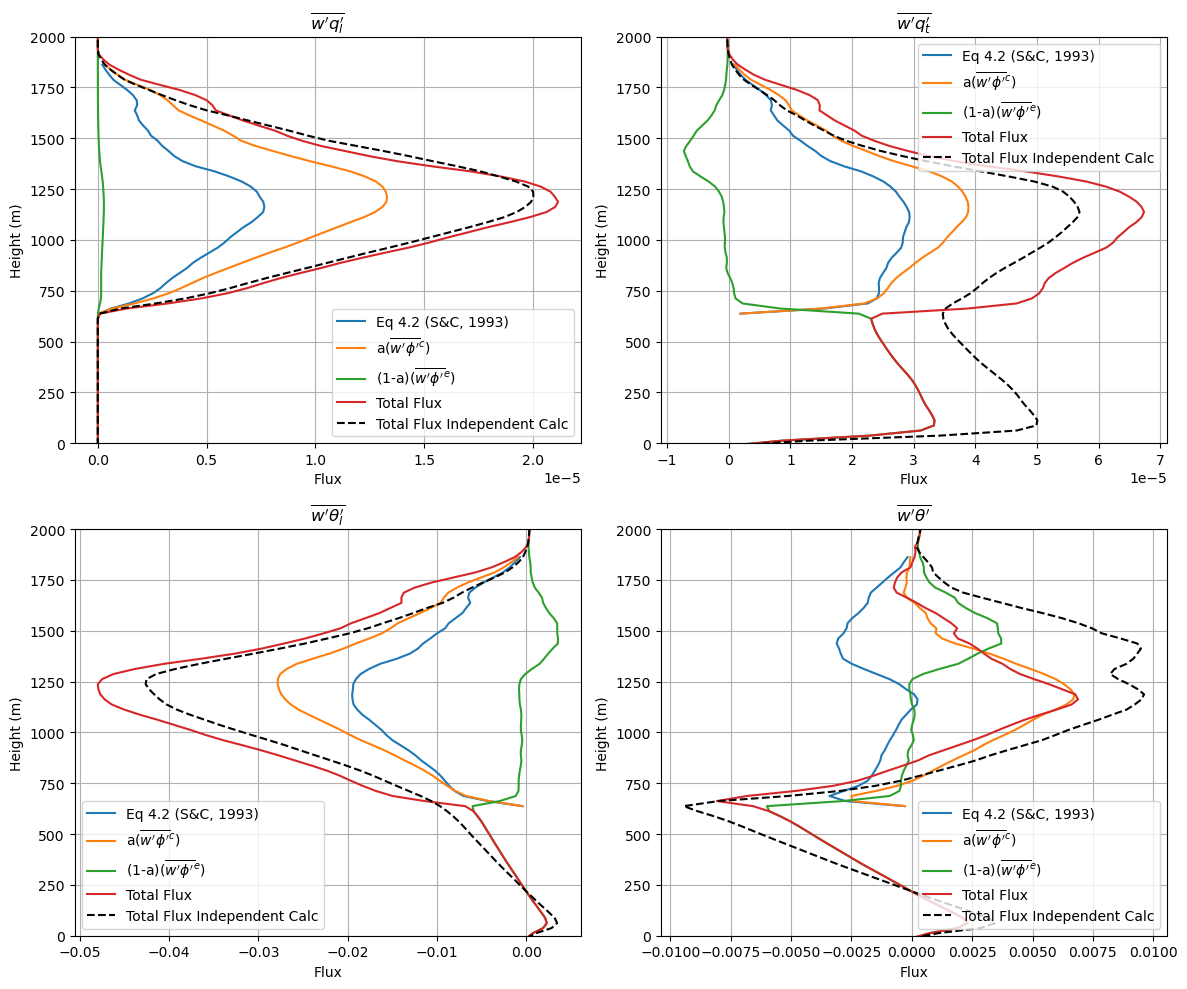

In [14]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt

# # Threshold for liquid water content
# liquid_water_threshold = 1e-5

# # File paths
# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

# files = {
#     'w': data_dir + 'rico.w.nc',
#     'l': data_dir + 'rico.l.nc',
#     'q': data_dir + 'rico.q.nc',
#     't': data_dir + 'rico.t.nc',
#     'p': data_dir + 'rico.p.nc',
#     'theta': data_dir + 'rico.potential_temp.nc'
# }

# # Variable names in NetCDF files
# var_names = {
#     'w': 'w',
#     'l': 'l',
#     'q': 'q',
#     't': 't',
#     'theta': 'potential_temperature'
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         return ds[var_name][timestep].astype(np.float64)

# def load_zt(filename):
#     with nc.Dataset(filename) as ds:
#         return ds['zt'][:]

# def calculate_M_c(w_data, l_data, var_data):
#     M_c_values = []
#     active_cloudy_values = []
#     environment_values = []
#     total_flux_values = []

#     # Loop over vertical levels
#     for z in range(w_data.shape[0]):
#         # Masks
#         cloudy = l_data[z] > liquid_water_threshold
#         environment = ~cloudy

#         # Area fraction
#         a = np.mean(cloudy)

#         # Means
#         w_mean = np.mean(w_data[z])
#         var_mean = np.mean(var_data[z])

#         # Initialize variables
#         w_c = np.nan
#         var_c = np.nan
#         w_e = np.nan
#         var_e = np.nan

#         # Cloudy calculations
#         if np.any(cloudy):
#             w_c = np.mean(w_data[z][cloudy])
#             var_c = np.mean(var_data[z][cloudy])
#             line1 = a * np.mean((w_data[z][cloudy] - w_mean) * (var_data[z][cloudy] - var_mean))
#         else:
#             line1 = np.nan

#         # Environment calculations
#         if np.any(environment):
#             w_e = np.mean(w_data[z][environment])
#             var_e = np.mean(var_data[z][environment])
#             line2 = (1 - a) * np.mean((w_data[z][environment] - w_mean) * (var_data[z][environment] - var_mean))
#         else:
#             line2 = np.nan

#         # Mass flux term
#         if not any(np.isnan([w_c, w_e, var_c, var_e])):
#             M_c = a * (1 - a) * (w_c - w_e) * (var_c - var_e)
#         else:
#             M_c = np.nan

#         # Total flux
#         total_flux = np.nansum([M_c, line1, line2])

#         # Append results
#         M_c_values.append(M_c)
#         active_cloudy_values.append(line1)
#         environment_values.append(line2)
#         total_flux_values.append(total_flux)

#     return map(np.array, [M_c_values, active_cloudy_values, environment_values, total_flux_values])

# def average_over_time(start, end, var_key):
#     num_steps = end - start
#     M_c_sum = None

#     for t in range(start, end):
#         w_data = load_data(files['w'], var_names['w'], t)
#         l_data = load_data(files['l'], var_names['l'], t)
#         var_data = load_data(files[var_key], var_names[var_key], t)

#         results = calculate_M_c(w_data, l_data, var_data)

#         if M_c_sum is None:
#             M_c_sum = [np.zeros_like(r) for r in results]

#         for i, r in enumerate(results):
#             M_c_sum[i] += r

#     # Average over time
#     return [r / num_steps for r in M_c_sum]

# def calculate_total_flux_independent(var_data, w_data):
#     independent_flux = []
#     for z in range(var_data.shape[0]):
#         # Domain means at this level
#         var_mean = np.mean(var_data[z])
#         w_mean = np.mean(w_data[z])

#         # Calculate differences from domain means
#         var_prime = var_data[z] - var_mean
#         w_prime = w_data[z] - w_mean

#         # Compute the product and take the mean over the grid
#         total_flux_indep = np.mean(var_prime * w_prime)
#         independent_flux.append(total_flux_indep)

#     return np.array(independent_flux)

# # Time range
# start_timestep = 15
# end_timestep = 18

# # Load height values
# zt_values = load_zt(files['l'])

# # Variables to process with their titles
# variables = {
#     'l': r'$\overline{w^{\prime}q_l^{\prime}}$',
#     'q': r'$\overline{w^{\prime}q_t^{\prime}}$',
#     't': r'$\overline{w^{\prime}\theta_l^{\prime}}$',
#     'theta': r'$\overline{w^{\prime}\theta^{\prime}}$'
# }

# # Store results
# results = {}

# for var_key, title in variables.items():
#     results[var_key] = {}
#     M_c_values, active_cloudy, environment, total_flux = average_over_time(start_timestep, end_timestep, var_key)
#     results[var_key]['M_c'] = M_c_values
#     results[var_key]['active_cloudy'] = active_cloudy
#     results[var_key]['environment'] = environment
#     results[var_key]['total_flux'] = total_flux
#     results[var_key]['title'] = title

#     # Calculate independent total flux
#     total_flux_independent_all_timesteps = []
#     for t in range(start_timestep, end_timestep):
#         var_data = load_data(files[var_key], var_names[var_key], t)
#         w_data = load_data(files['w'], var_names['w'], t)
#         total_flux_independent_all_timesteps.append(calculate_total_flux_independent(var_data, w_data))

#     # Average over timesteps
#     results[var_key]['total_flux_independent_calc'] = np.mean(total_flux_independent_all_timesteps, axis=0)

# # Plotting
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# axs = axs.flatten()

# for ax, (var_key, res) in zip(axs, results.items()):
#     ax.plot(res['M_c'], zt_values, label='Eq 4.2 (S&C, 1993)')
#     ax.plot(res['active_cloudy'], zt_values, label='a($\\overline{w\'\\phi\'}^c$)')
#     ax.plot(res['environment'], zt_values, label='(1-a)($\\overline{w\'\\phi\'}^e$)')
#     ax.plot(res['total_flux'], zt_values, label='Total Flux')
#     ax.plot(res['total_flux_independent_calc'], zt_values, linestyle='--', color='black', label='Total Flux Independent Calc')

#     ax.set_xlabel('Flux')
#     ax.set_ylabel('Height (m)')
#     ax.set_title(res['title'])
#     ax.grid(True)
#     ax.set_ylim([0, 2000])
#     ax.legend()

# plt.tight_layout()
# plt.show()


## Adding a different way of calculating total mass flux independently, using Gu et al. paper

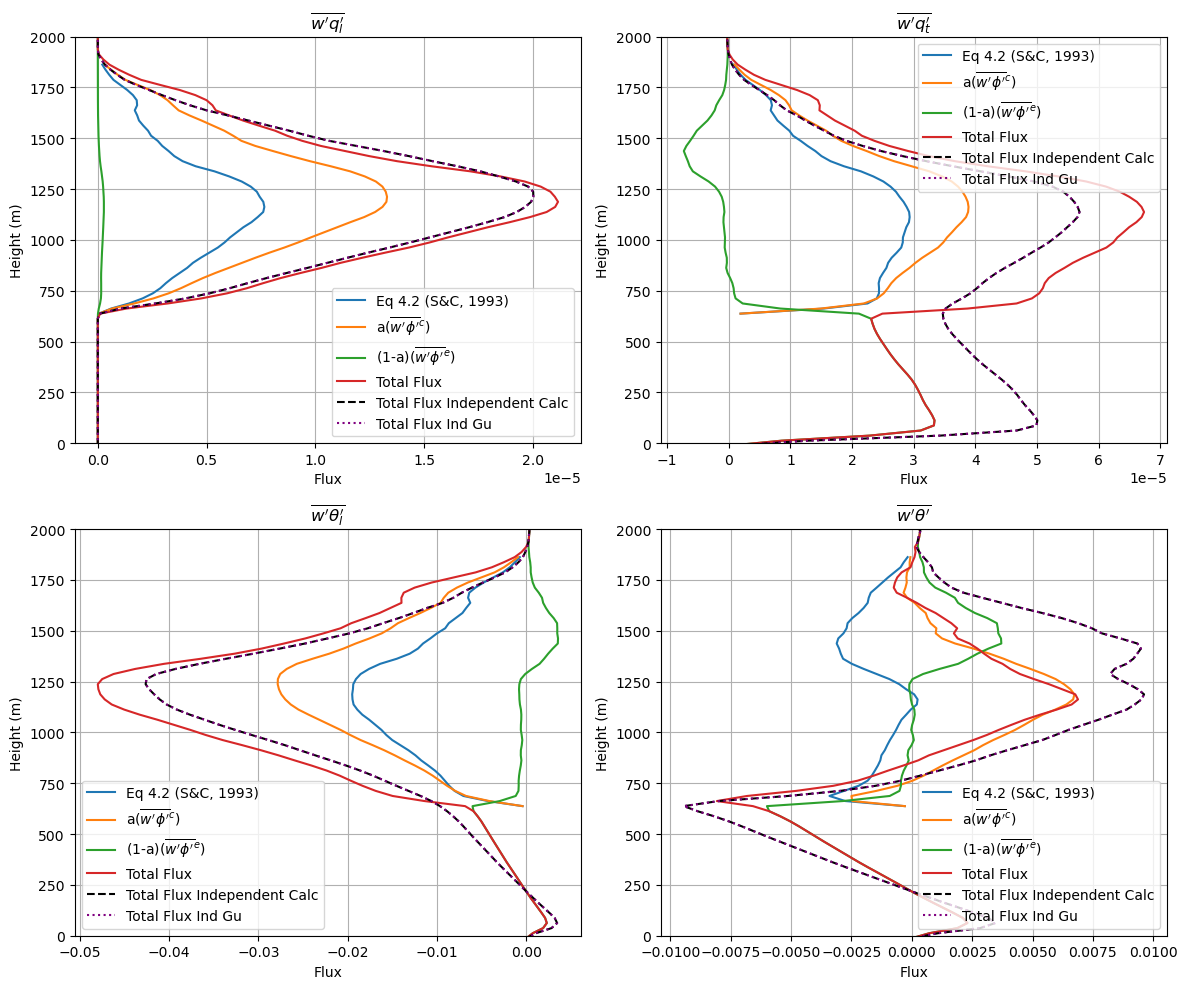

In [17]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt

# # Threshold for liquid water content
# liquid_water_threshold = 1e-5

# # File paths
# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

# files = {
#     'w': data_dir + 'rico.w.nc',
#     'l': data_dir + 'rico.l.nc',
#     'q': data_dir + 'rico.q.nc',
#     't': data_dir + 'rico.t.nc',
#     'p': data_dir + 'rico.p.nc',
#     'theta': data_dir + 'rico.potential_temp.nc'
# }

# # Variable names in NetCDF files
# var_names = {
#     'w': 'w',
#     'l': 'l',
#     'q': 'q',
#     't': 't',
#     'theta': 'potential_temperature'
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         return ds[var_name][timestep].astype(np.float64)

# def load_zt(filename):
#     with nc.Dataset(filename) as ds:
#         return ds['zt'][:]

# def calculate_M_c(w_data, l_data, var_data):
#     M_c_values = []
#     active_cloudy_values = []
#     environment_values = []
#     total_flux_values = []

#     # Loop over vertical levels
#     for z in range(w_data.shape[0]):
#         # Masks
#         cloudy = l_data[z] > liquid_water_threshold
#         environment = ~cloudy

#         # Area fraction
#         a = np.mean(cloudy)

#         # Means
#         w_mean = np.mean(w_data[z])
#         var_mean = np.mean(var_data[z])

#         # Initialize variables
#         w_c = np.nan
#         var_c = np.nan
#         w_e = np.nan
#         var_e = np.nan

#         # Cloudy calculations
#         if np.any(cloudy):
#             w_c = np.mean(w_data[z][cloudy])
#             var_c = np.mean(var_data[z][cloudy])
#             line1 = a * np.mean((w_data[z][cloudy] - w_mean) * (var_data[z][cloudy] - var_mean))
#         else:
#             line1 = np.nan

#         # Environment calculations
#         if np.any(environment):
#             w_e = np.mean(w_data[z][environment])
#             var_e = np.mean(var_data[z][environment])
#             line2 = (1 - a) * np.mean((w_data[z][environment] - w_mean) * (var_data[z][environment] - var_mean))
#         else:
#             line2 = np.nan

#         # Mass flux term
#         if not any(np.isnan([w_c, w_e, var_c, var_e])):
#             M_c = a * (1 - a) * (w_c - w_e) * (var_c - var_e)
#         else:
#             M_c = np.nan

#         # Total flux
#         total_flux = np.nansum([M_c, line1, line2])

#         # Append results
#         M_c_values.append(M_c)
#         active_cloudy_values.append(line1)
#         environment_values.append(line2)
#         total_flux_values.append(total_flux)

#     return map(np.array, [M_c_values, active_cloudy_values, environment_values, total_flux_values])

# def average_over_time(start, end, var_key):
#     num_steps = end - start
#     M_c_sum = None

#     for t in range(start, end):
#         w_data = load_data(files['w'], var_names['w'], t)
#         l_data = load_data(files['l'], var_names['l'], t)
#         var_data = load_data(files[var_key], var_names[var_key], t)

#         results = calculate_M_c(w_data, l_data, var_data)

#         if M_c_sum is None:
#             M_c_sum = [np.zeros_like(r) for r in results]

#         for i, r in enumerate(results):
#             M_c_sum[i] += r

#     # Average over time
#     return [r / num_steps for r in M_c_sum]

# def calculate_total_flux_independent(var_data, w_data):
#     independent_flux = []
#     for z in range(var_data.shape[0]):
#         # Domain means at this level
#         var_mean = np.mean(var_data[z])
#         w_mean = np.mean(w_data[z])

#         # Calculate differences from domain means
#         var_prime = var_data[z] - var_mean
#         w_prime = w_data[z] - w_mean

#         # Compute the product and take the mean over the grid
#         total_flux_indep = np.mean(var_prime * w_prime)
#         independent_flux.append(total_flux_indep)

#     return np.array(independent_flux)

# def calculate_total_flux_ind_Gu(var_data, w_data):
#     total_flux_Gu = []
#     for z in range(var_data.shape[0]):
#         # Step A: Multiply each grid point value of w and var_data, then average over the level
#         product_mean = np.mean(w_data[z] * var_data[z])

#         # Step B: Calculate the mean of w and var_data separately, then multiply
#         w_mean = np.mean(w_data[z])
#         var_mean = np.mean(var_data[z])
#         mean_product = w_mean * var_mean

#         # Calculate A - B
#         total_flux_Gu_level = product_mean - mean_product
#         total_flux_Gu.append(total_flux_Gu_level)

#     return np.array(total_flux_Gu)

# # Time range
# start_timestep = 15
# end_timestep = 18

# # Load height values
# zt_values = load_zt(files['l'])

# # Variables to process with their titles
# variables = {
#     'l': r'$\overline{w^{\prime}q_l^{\prime}}$',
#     'q': r'$\overline{w^{\prime}q_t^{\prime}}$',
#     't': r'$\overline{w^{\prime}\theta_l^{\prime}}$',
#     'theta': r'$\overline{w^{\prime}\theta^{\prime}}$'
# }

# # Store results
# results = {}

# for var_key, title in variables.items():
#     results[var_key] = {}
#     M_c_values, active_cloudy, environment, total_flux = average_over_time(start_timestep, end_timestep, var_key)
#     results[var_key]['M_c'] = M_c_values
#     results[var_key]['active_cloudy'] = active_cloudy
#     results[var_key]['environment'] = environment
#     results[var_key]['total_flux'] = total_flux
#     results[var_key]['title'] = title

#     # Calculate independent total flux
#     total_flux_independent_all_timesteps = []
#     total_flux_Gu_all_timesteps = []
#     for t in range(start_timestep, end_timestep):
#         var_data = load_data(files[var_key], var_names[var_key], t)
#         w_data = load_data(files['w'], var_names['w'], t)

#         # Calculate both types of independent fluxes
#         total_flux_independent_all_timesteps.append(calculate_total_flux_independent(var_data, w_data))
#         total_flux_Gu_all_timesteps.append(calculate_total_flux_ind_Gu(var_data, w_data))

#     # Average over timesteps for each type of flux
#     results[var_key]['total_flux_independent_calc'] = np.mean(total_flux_independent_all_timesteps, axis=0)
#     results[var_key]['total_flux_ind_Gu'] = np.mean(total_flux_Gu_all_timesteps, axis=0)

# # Plotting
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# axs = axs.flatten()

# for ax, (var_key, res) in zip(axs, results.items()):
#     ax.plot(res['M_c'], zt_values, label='Eq 4.2 (S&C, 1993)')
#     ax.plot(res['active_cloudy'], zt_values, label='a($\\overline{w\'\\phi\'}^c$)')
#     ax.plot(res['environment'], zt_values, label='(1-a)($\\overline{w\'\\phi\'}^e$)')
#     ax.plot(res['total_flux'], zt_values, label='Total Flux')
#     ax.plot(res['total_flux_independent_calc'], zt_values, linestyle='--', color='black', label='Total Flux Independent Calc')
#     ax.plot(res['total_flux_ind_Gu'], zt_values, linestyle=':', color='purple', label='Total Flux Ind Gu')

#     ax.set_xlabel('Flux')
#     ax.set_ylabel('Height (m)')
#     ax.set_title(res['title'])
#     ax.grid(True)
#     ax.set_ylim([0, 2000])
#     ax.legend()

# plt.tight_layout()
# plt.show()


## Adding the missing term from Gu et al

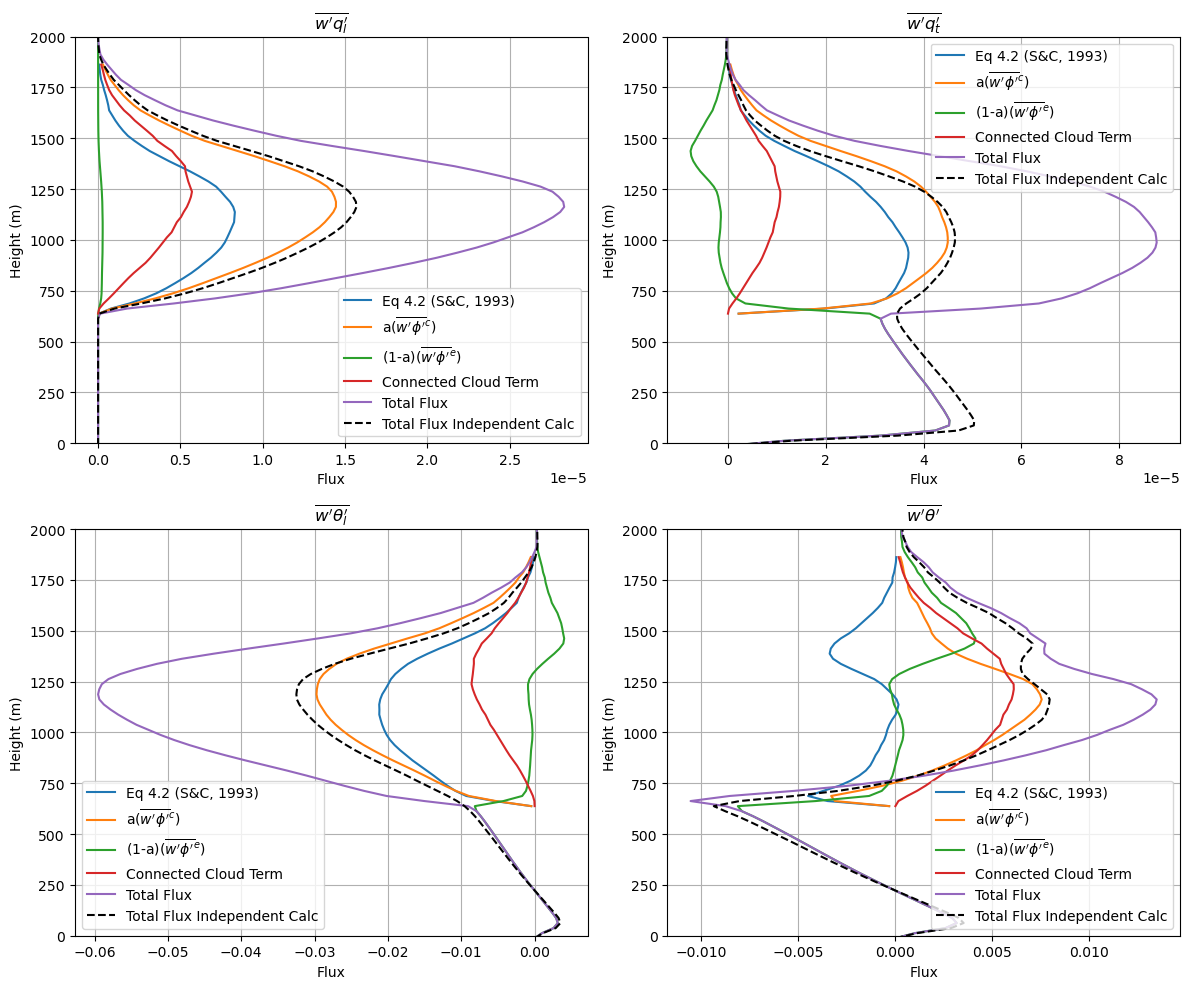

In [4]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt
# from scipy.ndimage import label, generate_binary_structure

# # Threshold for liquid water content
# liquid_water_threshold = 1e-5

# # File paths
# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

# files = {
#     'w': data_dir + 'rico.w.nc',
#     'l': data_dir + 'rico.l.nc',
#     'q': data_dir + 'rico.q.nc',
#     't': data_dir + 'rico.t.nc',
#     'p': data_dir + 'rico.p.nc',
#     'theta': data_dir + 'rico.potential_temp.nc'
# }

# # Variable names in NetCDF files
# var_names = {
#     'w': 'w',
#     'l': 'l',
#     'q': 'q',
#     't': 't',
#     'theta': 'potential_temperature'
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         return ds[var_name][timestep].astype(np.float64)

# def load_zt(filename):
#     with nc.Dataset(filename) as ds:
#         return ds['zt'][:]

# def calculate_M_c(w_data, l_data, var_data):
#     M_c_values = []
#     active_cloudy_values = []
#     environment_values = []
#     line3_values = []
#     total_flux_values = []

#     # Loop over vertical levels
#     for z in range(w_data.shape[0]):
#         # Masks
#         cloudy = l_data[z] > liquid_water_threshold
#         environment = ~cloudy

#         # Area fraction
#         a = np.mean(cloudy)

#         # Means
#         w_mean = np.mean(w_data[z])
#         var_mean = np.mean(var_data[z])

#         # Initialize variables
#         w_c = np.nan
#         var_c = np.nan
#         w_e = np.nan
#         var_e = np.nan

#         # Cloudy calculations
#         if np.any(cloudy):
#             w_c = np.mean(w_data[z][cloudy])
#             var_c = np.mean(var_data[z][cloudy])
#             line1 = a * np.mean((w_data[z][cloudy] - w_mean) * (var_data[z][cloudy] - var_mean))
#         else:
#             line1 = np.nan

#         # Environment calculations
#         if np.any(environment):
#             w_e = np.mean(w_data[z][environment])
#             var_e = np.mean(var_data[z][environment])
#             line2 = (1 - a) * np.mean((w_data[z][environment] - w_mean) * (var_data[z][environment] - var_mean))
#         else:
#             line2 = np.nan

#         # Mass flux term
#         if not any(np.isnan([w_c, w_e, var_c, var_e])):
#             M_c = a * (1 - a) * (w_c - w_e) * (var_c - var_e)
#         else:
#             M_c = np.nan

#         # New term calculations (line3)
#         if np.any(cloudy):
#             # Label connected clouds using an 8-connected neighborhood
#             structure = generate_binary_structure(2, 2)  # 8-connected
#             labeled_clouds, num_features = label(cloudy, structure=structure)

#             line3 = 0.0  # Initialize line3 for this level

#             # Total number of points at this level
#             total_points = cloudy.shape[0] * cloudy.shape[1]

#             # Loop over each cloud
#             for cloud_label in range(1, num_features + 1):
#                 # Mask for the current cloud
#                 cloud_mask = labeled_clouds == cloud_label

#                 # Area fraction of the cloud
#                 area_fraction = np.sum(cloud_mask) / total_points

#                 # Mean w and var in the cloud
#                 w_cloud_mean = np.mean(w_data[z][cloud_mask])
#                 var_cloud_mean = np.mean(var_data[z][cloud_mask])

#                 # Deviations from cloud means
#                 w_prime = w_data[z][cloud_mask] - w_cloud_mean
#                 var_prime = var_data[z][cloud_mask] - var_cloud_mean

#                 # Compute the product and sum over the cloud
#                 cloud_contribution = area_fraction * np.mean(w_prime * var_prime)

#                 # Sum contributions from all clouds
#                 line3 += cloud_contribution

#             # If no clouds, set line3 to nan
#             if num_features == 0:
#                 line3 = np.nan
#         else:
#             line3 = np.nan

#         # Total flux including the new term
#         total_flux = np.nansum([M_c, line1, line2, line3])

#         # Append results
#         M_c_values.append(M_c)
#         active_cloudy_values.append(line1)
#         environment_values.append(line2)
#         line3_values.append(line3)
#         total_flux_values.append(total_flux)

#     return map(np.array, [M_c_values, active_cloudy_values, environment_values, line3_values, total_flux_values])

# def average_over_time(start, end, var_key):
#     num_steps = end - start
#     M_c_sum = None

#     for t in range(start, end):
#         w_data = load_data(files['w'], var_names['w'], t)
#         l_data = load_data(files['l'], var_names['l'], t)
#         var_data = load_data(files[var_key], var_names[var_key], t)

#         results = calculate_M_c(w_data, l_data, var_data)

#         if M_c_sum is None:
#             M_c_sum = [np.zeros_like(r) for r in results]

#         for i, r in enumerate(results):
#             M_c_sum[i] += r

#     # Average over time
#     return [r / num_steps for r in M_c_sum]

# def calculate_total_flux_independent(var_data, w_data):
#     independent_flux = []
#     for z in range(var_data.shape[0]):
#         # Domain means at this level
#         var_mean = np.mean(var_data[z])
#         w_mean = np.mean(w_data[z])

#         # Calculate differences from domain means
#         var_prime = var_data[z] - var_mean
#         w_prime = w_data[z] - w_mean

#         # Compute the product and take the mean over the grid
#         total_flux_indep = np.mean(var_prime * w_prime)
#         independent_flux.append(total_flux_indep)

#     return np.array(independent_flux)

# # Time range
# start_timestep = 8
# end_timestep = 18

# # Load height values
# zt_values = load_zt(files['l'])

# # Variables to process with their titles
# variables = {
#     'l': r'$\overline{w^{\prime}q_l^{\prime}}$',
#     'q': r'$\overline{w^{\prime}q_t^{\prime}}$',
#     't': r'$\overline{w^{\prime}\theta_l^{\prime}}$',
#     'theta': r'$\overline{w^{\prime}\theta^{\prime}}$'
# }

# # Store results
# results = {}

# for var_key, title in variables.items():
#     results[var_key] = {}
#     M_c_values, active_cloudy, environment, line3_values, total_flux = average_over_time(start_timestep, end_timestep, var_key)
#     results[var_key]['M_c'] = M_c_values
#     results[var_key]['active_cloudy'] = active_cloudy
#     results[var_key]['environment'] = environment
#     results[var_key]['line3'] = line3_values
#     results[var_key]['total_flux'] = total_flux
#     results[var_key]['title'] = title

#     # Calculate independent total flux
#     total_flux_independent_all_timesteps = []
#     for t in range(start_timestep, end_timestep):
#         var_data = load_data(files[var_key], var_names[var_key], t)
#         w_data = load_data(files['w'], var_names['w'], t)
#         total_flux_independent_all_timesteps.append(calculate_total_flux_independent(var_data, w_data))

#     # Average over timesteps
#     results[var_key]['total_flux_independent_calc'] = np.mean(total_flux_independent_all_timesteps, axis=0)

# # Plotting
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# axs = axs.flatten()

# for ax, (var_key, res) in zip(axs, results.items()):
#     ax.plot(res['M_c'], zt_values, label='Eq 4.2 (S&C, 1993)')
#     ax.plot(res['active_cloudy'], zt_values, label='a($\\overline{w\'\\phi\'}^c$)')
#     ax.plot(res['environment'], zt_values, label='(1-a)($\\overline{w\'\\phi\'}^e$)')
#     ax.plot(res['line3'], zt_values, label='Connected Cloud Term')
#     ax.plot(res['total_flux'], zt_values, label='Total Flux')
#     ax.plot(res['total_flux_independent_calc'], zt_values, linestyle='--', color='black', label='Total Flux Independent Calc')

#     ax.set_xlabel('Flux')
#     ax.set_ylabel('Height (m)')
#     ax.set_title(res['title'])
#     ax.grid(True)
#     ax.set_ylim([0, 2000])
#     ax.legend()

# plt.tight_layout()
# plt.show()


# Updated buoyancy criterion

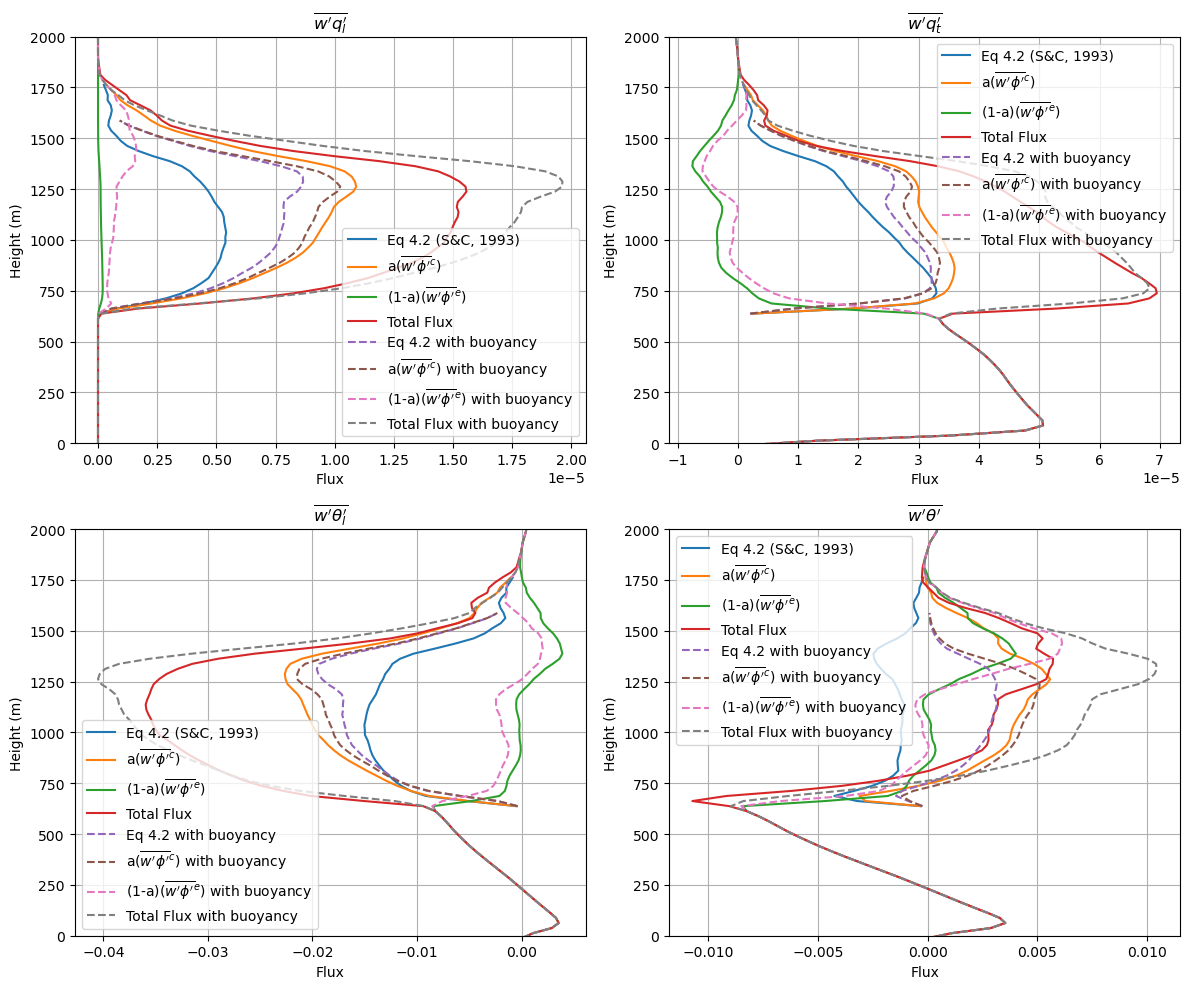

In [9]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Thresholds
liquid_water_threshold = 1e-5

# File paths
data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

files = {
    'w': data_dir + 'rico.w.nc',
    'l': data_dir + 'rico.l.nc',
    'q': data_dir + 'rico.q.nc',
    't': data_dir + 'rico.t.nc',
    'theta': data_dir + 'rico.potential_temp.nc',
    'buoyancy': data_dir + 'rico.buoyancy.nc'
}

var_names = {
    'w': 'w',
    'l': 'l',
    'q': 'q',
    't': 't',
    'theta': 'potential_temperature',
    'buoyancy': 'buoyancy'
}

def load_data(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        return ds[var_name][timestep].astype(np.float64)

def load_zt(filename):
    with nc.Dataset(filename) as ds:
        return ds['zt'][:]

def calculate_M_c(w_data, l_data, var_data, buoyancy_data=None):
    M_c_values = []
    active_cloudy_values = []
    environment_values = []
    total_flux_values = []

    for z in range(w_data.shape[0]):
        # Create masks
        if buoyancy_data is not None:
            cloudy = (l_data[z] > liquid_water_threshold) & (buoyancy_data[z] > 0)
        else:
            cloudy = l_data[z] > liquid_water_threshold
        environment = ~cloudy

        # Area fraction
        a = np.mean(cloudy)

        # Means
        w_mean = np.mean(w_data[z])
        var_mean = np.mean(var_data[z])

        # Initialize variables
        w_c = w_e = var_c = var_e = np.nan

        # Cloudy calculations
        if np.any(cloudy):
            w_c = np.mean(w_data[z][cloudy])
            var_c = np.mean(var_data[z][cloudy])
            line1 = a * np.mean((w_data[z][cloudy] - w_mean) * (var_data[z][cloudy] - var_mean))
        else:
            line1 = np.nan

        # Environment calculations
        if np.any(environment):
            w_e = np.mean(w_data[z][environment])
            var_e = np.mean(var_data[z][environment])
            line2 = (1 - a) * np.mean((w_data[z][environment] - w_mean) * (var_data[z][environment] - var_mean))
        else:
            line2 = np.nan

        # Mass flux term
        if not any(np.isnan([w_c, w_e, var_c, var_e])):
            M_c = a * (1 - a) * (w_c - w_e) * (var_c - var_e)
        else:
            M_c = np.nan

        # Total flux
        total_flux = np.nansum([M_c, line1, line2])

        # Append results
        M_c_values.append(M_c)
        active_cloudy_values.append(line1)
        environment_values.append(line2)
        total_flux_values.append(total_flux)

    return [np.array(M_c_values), np.array(active_cloudy_values), np.array(environment_values), np.array(total_flux_values)]

def average_over_time(start, end, var_key, use_buoyancy=False):
    num_steps = end - start
    M_c_sum = None

    for t in range(start, end):
        w_data = load_data(files['w'], var_names['w'], t)
        l_data = load_data(files['l'], var_names['l'], t)
        var_data = load_data(files[var_key], var_names[var_key], t)
        buoyancy_data = load_data(files['buoyancy'], var_names['buoyancy'], t) if use_buoyancy else None

        results = calculate_M_c(w_data, l_data, var_data, buoyancy_data)

        if M_c_sum is None:
            M_c_sum = [np.zeros_like(r) for r in results]

        for i, r in enumerate(results):
            M_c_sum[i] += r

    # Average over time
    return [r / num_steps for r in M_c_sum]

# Time range
start_timestep = 15
end_timestep = 18

# Load height values
zt_values = load_zt(files['l'])

# Variables to process
variables = {
    'l': {
        'title': r'$\overline{w^{\prime}q_l^{\prime}}$'
    },
    'q': {
        'title': r'$\overline{w^{\prime}q_t^{\prime}}$'
    },
    't': {
        'title': r'$\overline{w^{\prime}\theta_l^{\prime}}$'
    },
    'theta': {
        'title': r'$\overline{w^{\prime}\theta^{\prime}}$'
    }
}

# Store results
results = {}

for var_key, info in variables.items():
    results[var_key] = {}

    # Without buoyancy threshold
    M_c_values, active_cloudy, environment, total_flux = average_over_time(
        start_timestep, end_timestep, var_key, use_buoyancy=False
    )
    results[var_key]['no_buoyancy'] = {
        'M_c': M_c_values,
        'active_cloudy': active_cloudy,
        'environment': environment,
        'total_flux': total_flux
    }

    # With buoyancy threshold
    M_c_values_b, active_cloudy_b, environment_b, total_flux_b = average_over_time(
        start_timestep, end_timestep, var_key, use_buoyancy=True
    )
    results[var_key]['with_buoyancy'] = {
        'M_c': M_c_values_b,
        'active_cloudy': active_cloudy_b,
        'environment': environment_b,
        'total_flux': total_flux_b
    }

    results[var_key]['title'] = info['title']

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for ax, (var_key, res) in zip(axs, results.items()):
    # Without buoyancy
    ax.plot(res['no_buoyancy']['M_c'], zt_values, label='Eq 4.2 (S&C, 1993)')
    ax.plot(res['no_buoyancy']['active_cloudy'], zt_values, label='a($\\overline{w\'\\phi\'}^c$)')
    ax.plot(res['no_buoyancy']['environment'], zt_values, label='(1-a)($\\overline{w\'\\phi\'}^e$)')
    ax.plot(res['no_buoyancy']['total_flux'], zt_values, label='Total Flux')

    # With buoyancy (dashed lines)
    ax.plot(res['with_buoyancy']['M_c'], zt_values, linestyle='--', label='Eq 4.2 with buoyancy')
    ax.plot(res['with_buoyancy']['active_cloudy'], zt_values, linestyle='--', label='a($\\overline{w\'\\phi\'}^c$) with buoyancy')
    ax.plot(res['with_buoyancy']['environment'], zt_values, linestyle='--', label='(1-a)($\\overline{w\'\\phi\'}^e$) with buoyancy')
    ax.plot(res['with_buoyancy']['total_flux'], zt_values, linestyle='--', label='Total Flux with buoyancy')

    ax.set_xlabel('Flux')
    ax.set_ylabel('Height (m)')
    ax.set_title(res['title'])
    ax.grid(True)
    ax.set_ylim([0, 2000])
    ax.legend()

plt.tight_layout()
plt.show()


# Different way of showing difference between liquid water and liquid water + buoyancy threshold

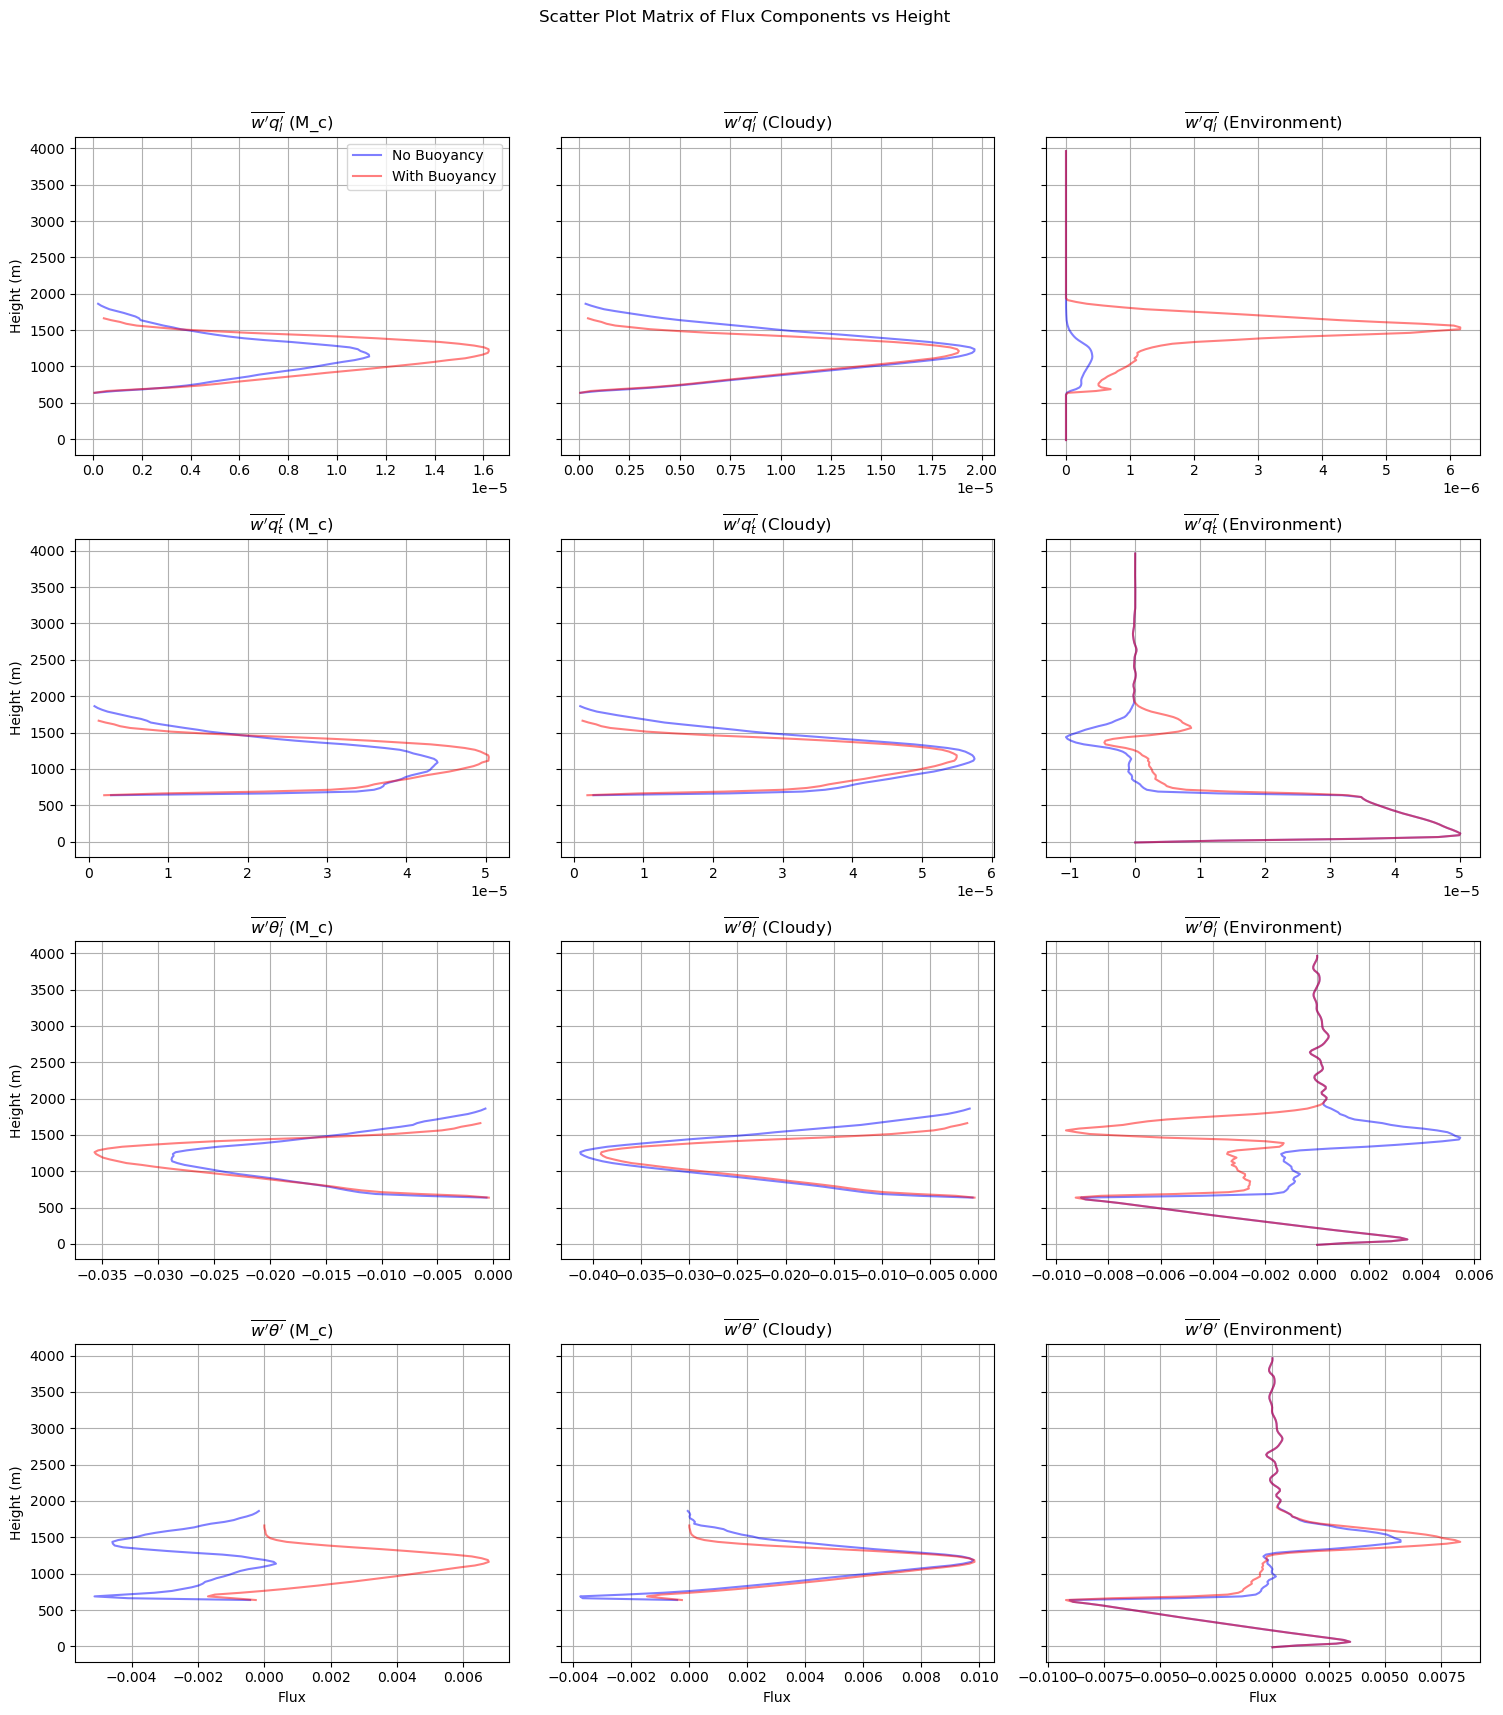

In [11]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Thresholds
liquid_water_threshold = 1e-5

# File paths
data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

files = {
    'w': data_dir + 'rico.w.nc',
    'l': data_dir + 'rico.l.nc',
    'q': data_dir + 'rico.q.nc',
    't': data_dir + 'rico.t.nc',
    'theta': data_dir + 'rico.potential_temp.nc',
    'buoyancy': data_dir + 'rico.buoyancy.nc'
}

var_names = {
    'w': 'w',
    'l': 'l',
    'q': 'q',
    't': 't',
    'theta': 'potential_temperature',
    'buoyancy': 'buoyancy'
}

def load_data(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        return ds[var_name][timestep].astype(np.float64)

def load_zt(filename):
    with nc.Dataset(filename) as ds:
        return ds['zt'][:]

def calculate_M_c(w_data, l_data, var_data, buoyancy_data=None):
    M_c_values = []
    active_cloudy_values = []
    environment_values = []
    total_flux_values = []

    for z in range(w_data.shape[0]):
        # Create masks
        if buoyancy_data is not None:
            cloudy = (l_data[z] > liquid_water_threshold) & (buoyancy_data[z] > 0)
        else:
            cloudy = l_data[z] > liquid_water_threshold
        environment = ~cloudy

        # Area fraction
        a = np.mean(cloudy)

        # Means
        w_mean = np.mean(w_data[z])
        var_mean = np.mean(var_data[z])

        # Initialize variables
        w_c = w_e = var_c = var_e = np.nan

        # Cloudy calculations
        if np.any(cloudy):
            w_c = np.mean(w_data[z][cloudy])
            var_c = np.mean(var_data[z][cloudy])
            line1 = a * np.mean((w_data[z][cloudy] - w_mean) * (var_data[z][cloudy] - var_mean))
        else:
            line1 = np.nan

        # Environment calculations
        if np.any(environment):
            w_e = np.mean(w_data[z][environment])
            var_e = np.mean(var_data[z][environment])
            line2 = (1 - a) * np.mean((w_data[z][environment] - w_mean) * (var_data[z][environment] - var_mean))
        else:
            line2 = np.nan

        # Mass flux term
        if not any(np.isnan([w_c, w_e, var_c, var_e])):
            M_c = a * (1 - a) * (w_c - w_e) * (var_c - var_e)
        else:
            M_c = np.nan

        # Total flux
        total_flux = np.nansum([M_c, line1, line2])

        # Append results
        M_c_values.append(M_c)
        active_cloudy_values.append(line1)
        environment_values.append(line2)
        total_flux_values.append(total_flux)

    return [np.array(M_c_values), np.array(active_cloudy_values), np.array(environment_values), np.array(total_flux_values)]

def average_over_time(start, end, var_key, use_buoyancy=False):
    num_steps = end - start
    M_c_sum = None

    for t in range(start, end):
        w_data = load_data(files['w'], var_names['w'], t)
        l_data = load_data(files['l'], var_names['l'], t)
        var_data = load_data(files[var_key], var_names[var_key], t)
        buoyancy_data = load_data(files['buoyancy'], var_names['buoyancy'], t) if use_buoyancy else None

        results = calculate_M_c(w_data, l_data, var_data, buoyancy_data)

        if M_c_sum is None:
            M_c_sum = [np.zeros_like(r) for r in results]

        for i, r in enumerate(results):
            M_c_sum[i] += r

    # Average over time
    return [r / num_steps for r in M_c_sum]

# Time range
start_timestep = 15
end_timestep = 18

# Load height values
zt_values = load_zt(files['l'])

# Variables to process
variables = {
    'l': r'$\overline{w^{\prime}q_l^{\prime}}$',
    'q': r'$\overline{w^{\prime}q_t^{\prime}}$',
    't': r'$\overline{w^{\prime}\theta_l^{\prime}}$',
    'theta': r'$\overline{w^{\prime}\theta^{\prime}}$'
}

# Store results
scatter_data = {}

for var_key, title in variables.items():
    # Without buoyancy threshold
    M_c_values, active_cloudy, environment, total_flux = average_over_time(
        start_timestep, end_timestep, var_key, use_buoyancy=False
    )
    scatter_data[var_key] = {
        'title': title,
        'no_buoyancy': {
            'M_c': M_c_values,
            'active_cloudy': active_cloudy,
            'environment': environment,
            'total_flux': total_flux
        }
    }

    # With buoyancy threshold
    M_c_values_b, active_cloudy_b, environment_b, total_flux_b = average_over_time(
        start_timestep, end_timestep, var_key, use_buoyancy=True
    )
    scatter_data[var_key]['with_buoyancy'] = {
        'M_c': M_c_values_b,
        'active_cloudy': active_cloudy_b,
        'environment': environment_b,
        'total_flux': total_flux_b
    }

# Scatter plot matrix
fig, axs = plt.subplots(4, 3, figsize=(15, 18), sharey=True)
fig.suptitle("Scatter Plot Matrix of Flux Components vs Height")

for i, (var_key, data) in enumerate(scatter_data.items()):
    title = data['title']
    
    # Plot each component for no buoyancy
    axs[i, 0].plot(data['no_buoyancy']['M_c'], zt_values, color='blue', alpha=0.5, label='No Buoyancy')
    axs[i, 1].plot(data['no_buoyancy']['active_cloudy'], zt_values, color='blue', alpha=0.5, label='No Buoyancy')
    axs[i, 2].plot(data['no_buoyancy']['environment'], zt_values, color='blue', alpha=0.5, label='No Buoyancy')
    
    # Plot each component for with buoyancy
    axs[i, 0].plot(data['with_buoyancy']['M_c'], zt_values, color='red', alpha=0.5, label='With Buoyancy')
    axs[i, 1].plot(data['with_buoyancy']['active_cloudy'], zt_values, color='red', alpha=0.5, label='With Buoyancy')
    axs[i, 2].plot(data['with_buoyancy']['environment'], zt_values, color='red', alpha=0.5, label='With Buoyancy')
    
    # Set titles and labels
    axs[i, 0].set_title(f'{title} (M_c)')
    axs[i, 1].set_title(f'{title} (Cloudy)')
    axs[i, 2].set_title(f'{title} (Environment)')
    axs[i, 0].set_ylabel('Height (m)')
    for j in range(3):
        axs[i, j].grid(True)

# Add legends to the first row
axs[0, 0].legend(loc='upper right')

# Set x-axis labels for the last row only
for j in range(3):
    axs[3, j].set_xlabel('Flux')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Percentiles plots (pdfs) for buoyancy and vertical velocity

In [55]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Threshold for liquid water content
liquid_water_threshold = 1e-5

# File paths
data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

files = {
    'w': data_dir + 'rico.w.nc',
    'buoyancy': data_dir + 'rico.buoyancy.nc',
    'l': data_dir + 'rico.l.nc'  # Liquid water content file
}

var_names = {
    'w': 'w',
    'buoyancy': 'buoyancy',
    'l': 'l'
}

# Time range
start_timestep = 4
end_timestep = 19

# Initialize lists to store selected values across timesteps
selected_w_values = []
selected_buoyancy_values = []

# Open each file once and iterate over timesteps inside
with nc.Dataset(files['w']) as w_ds, nc.Dataset(files['buoyancy']) as buoyancy_ds, nc.Dataset(files['l']) as l_ds:
    for t in range(start_timestep, end_timestep):
        print("Processing timestep", t)
        
        # Load data for each timestep and flatten immediately
        w_data = w_ds[var_names['w']][t].ravel()
        buoyancy_data = buoyancy_ds[var_names['buoyancy']][t].ravel()
        l_data = l_ds[var_names['l']][t].ravel()
        
        # Create a mask where liquid water content is above the threshold
        mask = l_data > liquid_water_threshold
        
        # Apply the mask to select values from w and buoyancy
        selected_w_values.extend(w_data[mask])
        selected_buoyancy_values.extend(buoyancy_data[mask])

# Convert lists to numpy arrays for plotting
all_w_values = np.array(selected_w_values)
all_buoyancy_values = np.array(selected_buoyancy_values)

Processing timestep 4
Processing timestep 5
Processing timestep 6
Processing timestep 7
Processing timestep 8
Processing timestep 9
Processing timestep 10
Processing timestep 11
Processing timestep 12
Processing timestep 13
Processing timestep 14
Processing timestep 15
Processing timestep 16
Processing timestep 17
Processing timestep 18


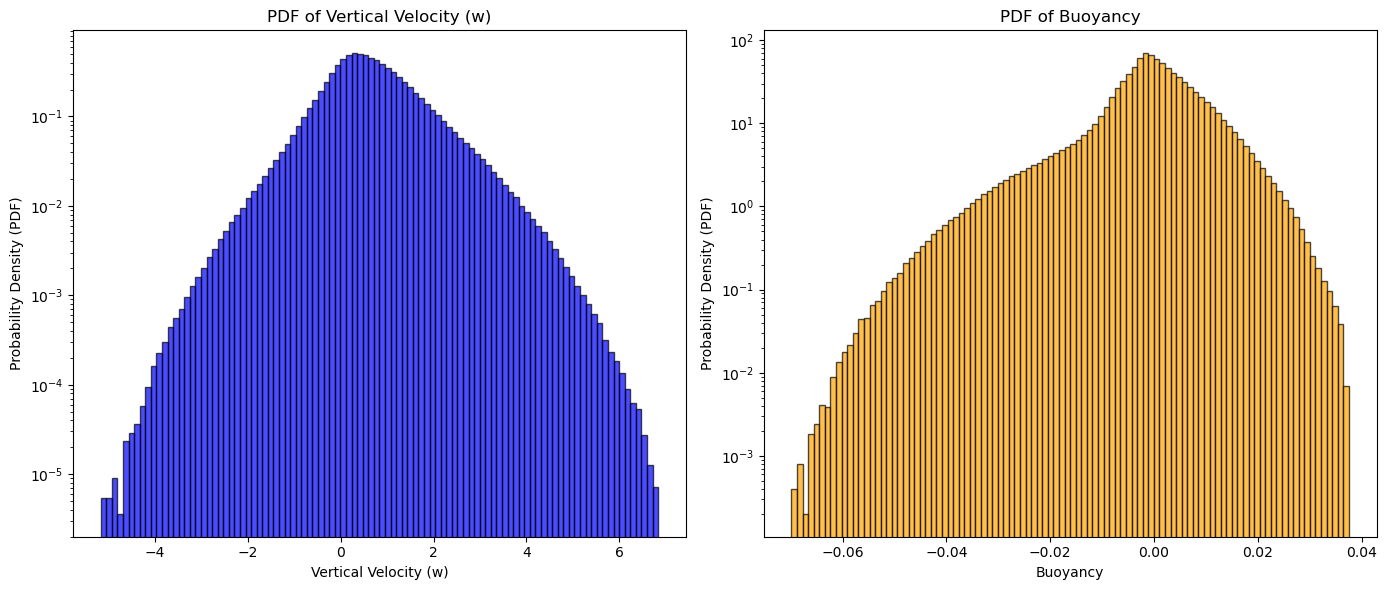

In [56]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for vertical velocity (w)
ax1.hist(all_w_values, bins=100, density=True, color='blue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Vertical Velocity (w)')
ax1.set_yscale('log')
ax1.set_ylabel('Probability Density (PDF)')
ax1.set_title('PDF of Vertical Velocity (w)')

# Histogram for buoyancy
ax2.hist(all_buoyancy_values, bins=100, density=True, color='orange', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Buoyancy')
ax2.set_yscale('log')
ax2.set_ylabel('Probability Density (PDF)')
ax2.set_title('PDF of Buoyancy')

plt.tight_layout()
plt.show()


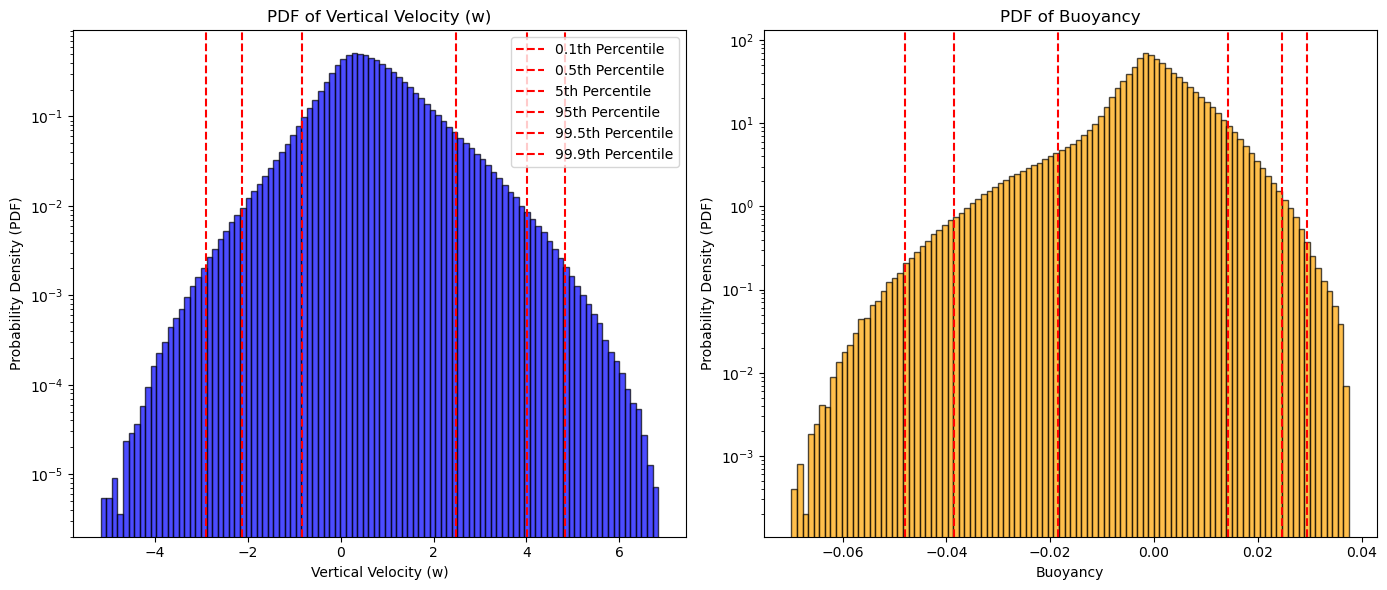

({'0.1th': -2.903475623369217,
  '0.5th': -2.1273748421669008,
  '5th': -0.835411223769188,
  '95th': 2.4759080886840756,
  '99.5th': 4.006912181377411,
  '99.9th': 4.835134343624142},
 {'0.1th': -0.04791126437857747,
  '0.5th': -0.03855712711811066,
  '5th': -0.01843685656785965,
  '95th': 0.014325679279863834,
  '99.5th': 0.024592220783233643,
  '99.9th': 0.02952328585833351})

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Percentiles to calculate
percentiles = [0.1, 0.5, 5, 95, 99.5, 99.9]

# Calculate percentiles for both datasets
w_percentiles = np.percentile(all_w_values, percentiles)
buoyancy_percentiles = np.percentile(all_buoyancy_values, percentiles)

# Print percentile values
w_percentiles_dict = {f"{p}th": value for p, value in zip(percentiles, w_percentiles)}
buoyancy_percentiles_dict = {f"{p}th": value for p, value in zip(percentiles, buoyancy_percentiles)}

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for vertical velocity (w)
ax1.hist(all_w_values, bins=100, density=True, color='blue', alpha=0.7, edgecolor='black')
for p, value in zip(percentiles, w_percentiles):
    ax1.axvline(value, color='red', linestyle='--', label=f'{p}th Percentile')
ax1.set_xlabel('Vertical Velocity (w)')
ax1.set_ylabel('Probability Density (PDF)')
ax1.set_yscale('log')  # Set y-axis to log scale
ax1.set_title('PDF of Vertical Velocity (w)')
ax1.legend(loc='upper right')

# Histogram for buoyancy
ax2.hist(all_buoyancy_values, bins=100, density=True, color='orange', alpha=0.7, edgecolor='black')
for p, value in zip(percentiles, buoyancy_percentiles):
    ax2.axvline(value, color='red', linestyle='--', label=f'{p}th Percentile')
ax2.set_xlabel('Buoyancy')
ax2.set_ylabel('Probability Density (PDF)')
ax2.set_yscale('log')  # Set y-axis to log scale
ax2.set_title('PDF of Buoyancy')

plt.tight_layout()
plt.show()

w_percentiles_dict, buoyancy_percentiles_dict


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


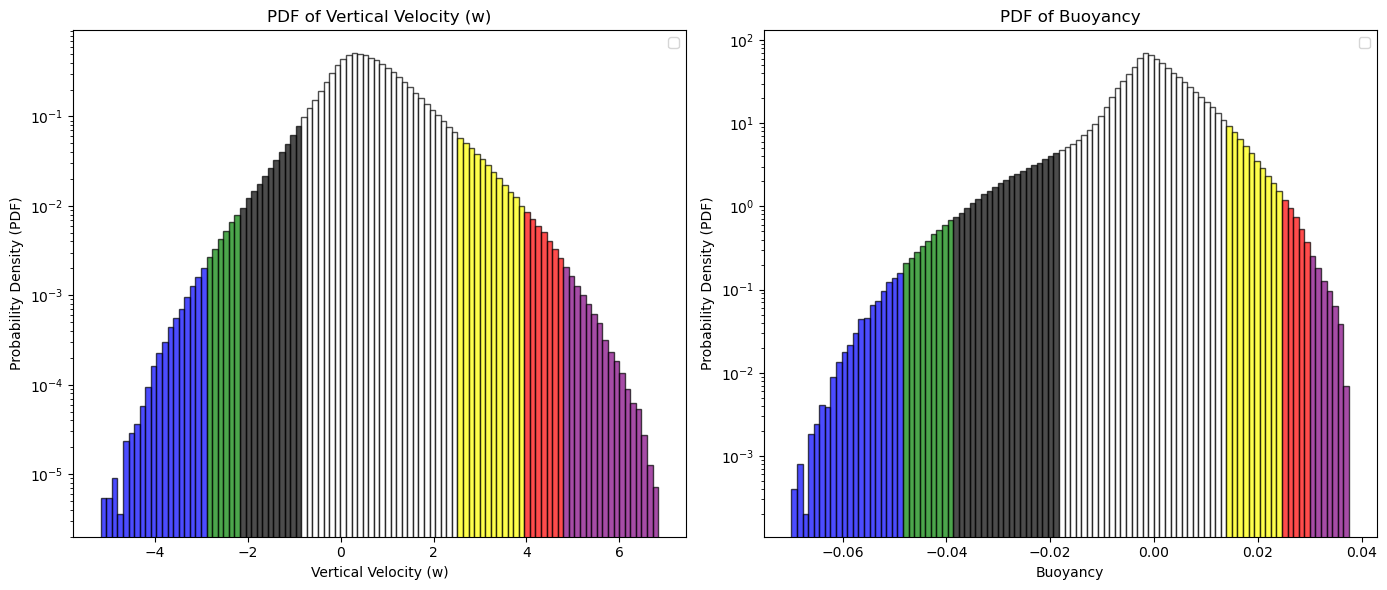

In [65]:
# Define colors for each percentile range
colors = ['blue', 'green', 'black', 'white', 'yellow', 'red', 'purple']

# Plotting with colored histogram sections
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Helper function to plot histogram with colored sections
def plot_histogram_with_colors(ax, data, percentiles, colors, xlabel, title):
    # Calculate histogram
    counts, bins, patches = ax.hist(data, bins=100, density=True, edgecolor='black', alpha=0.7)
    # Set color for each bin based on percentile ranges
    for i, patch in enumerate(patches):
        bin_center = (bins[i] + bins[i+1]) / 2
        if bin_center < percentiles[0]:
            patch.set_facecolor(colors[0])
        elif percentiles[0] <= bin_center < percentiles[1]:
            patch.set_facecolor(colors[1])
        elif percentiles[1] <= bin_center < percentiles[2]:
            patch.set_facecolor(colors[2])
        elif percentiles[2] <= bin_center < percentiles[3]:
            patch.set_facecolor(colors[3])
        elif percentiles[3] <= bin_center < percentiles[4]:
            patch.set_facecolor(colors[4])
        elif percentiles[4] <= bin_center < percentiles[5]:
            patch.set_facecolor(colors[5])
        else:
            patch.set_facecolor(colors[6])
    
#     # Add percentile lines
#     for p, value in zip(percentiles, percentiles):
#         ax.axvline(value, color='red', linestyle='--')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Probability Density (PDF)')
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot vertical velocity with color
plot_histogram_with_colors(ax1, all_w_values, w_percentiles, colors, 'Vertical Velocity (w)', 'PDF of Vertical Velocity (w)')

# Plot buoyancy with color
plot_histogram_with_colors(ax2, all_buoyancy_values, buoyancy_percentiles, colors, 'Buoyancy', 'PDF of Buoyancy')

plt.tight_layout()
plt.show()


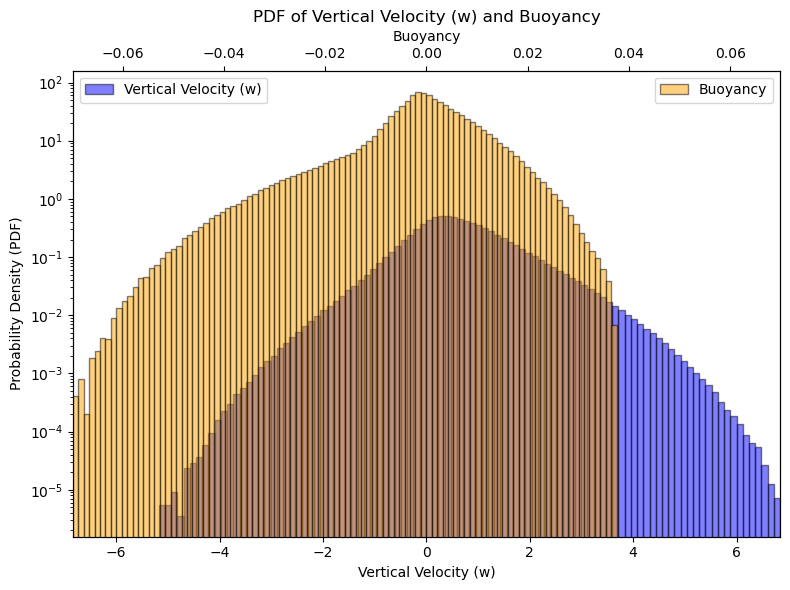

In [69]:
import matplotlib.pyplot as plt

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))

# Calculate the ranges for each dataset
w_min, w_max = min(all_w_values), max(all_w_values)
b_min, b_max = min(all_buoyancy_values), max(all_buoyancy_values)

# Determine the offset range for each dataset so that zero is centered
w_range = max(abs(w_min), abs(w_max))
b_range = max(abs(b_min), abs(b_max))

# Set x-axis limits for vertical velocity around zero
ax1.hist(all_w_values, bins=100, density=True, color='blue', alpha=0.5, edgecolor='black', label='Vertical Velocity (w)')
ax1.set_xlabel('Vertical Velocity (w)')
ax1.set_ylabel('Probability Density (PDF)')
ax1.set_yscale('log')
ax1.set_title('PDF of Vertical Velocity (w) and Buoyancy')
ax1.set_xlim(-w_range, w_range)  # Centering around zero
ax1.legend(loc="upper left")

# Create a twin x-axis for buoyancy histogram
ax2 = ax1.twiny()
ax2.hist(all_buoyancy_values, bins=100, density=True, color='orange', alpha=0.5, edgecolor='black', label='Buoyancy')
ax2.set_xlabel('Buoyancy')
ax2.set_yscale('log')
ax2.set_xlim(-b_range, b_range)  # Centering around zero
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()
